# Wasserstein Pareto Frontier Experiment on LSAC Data Set


## Import Data
The experiment used the CRIME data set as in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc. for comparison purpose: https://www.tensorflow.org/responsible_ai/fairness_indicators/tutorials/Fairness_Indicators_Pandas_Case_Study

In [1]:
import os
import ot
import math
import tempfile
import six.moves.urllib as urllib
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from scipy.linalg import sqrtm
from scipy import stats
from time import perf_counter

# Download the LSAT dataset and setup the required filepaths.
_DATA_ROOT = tempfile.mkdtemp(prefix='lsat-data')
_DATA_PATH = 'https://storage.googleapis.com/lawschool_dataset/bar_pass_prediction.csv'
_DATA_FILEPATH = os.path.join(_DATA_ROOT, 'bar_pass_prediction.csv')
data = urllib.request.urlopen(_DATA_PATH)
df = pd.read_csv(data)

# independnet variable features
X_features = ["gender","lsat","pass_bar","cluster","zfygpa","zgpa","fam_inc","age"]
# dependnet variable features
Y_features = ["gpa"]
# sensitive variable features
Z_features = ["race1"]

Data = df[["gender", "lsat","pass_bar","race1","cluster","zfygpa","zgpa","fam_inc","age","gpa"]]
# remove "nan"
Data_total = Data[((Data["gender"] == 'male') | (Data["gender"] == 'female')) & (Data["race1"] != 'nan')].dropna()
# create binary variables
Data_total = Data_total.replace(['female','male','white','asian', 'black', 'hisp', 'other'] , [0,1,0,1,1,1,1])

# independent variable w/o the sensitive variable: X_d
X_d = np.array(Data_total[X_features])
# direct sum of X_d and Z: X
X = np.array(Data_total[X_features+Z_features])
# dependent variable: Y
Y = np.array(Data_total[Y_features])[:,0]
# sensitive variable: Z
Z = np.array(Data_total[Z_features])[:,0]

# five-fold cross validation data sets
trainX_list = []
trainY_list = []
trainZ_list = []
testX_list = []
testY_list = []
testZ_list = []

for i in range(0,5):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1, random_state=i)
    trainX_list.append(trainX)
    testX_list.append(testX)
    trainY_list.append(trainY)
    testY_list.append(testY)
    trainZ_list.append((trainX[:,8] == 1)*1)
    testZ_list.append((testX[:,8] == 1)*1)
    

## Compute the Fair Data Representation (Wasserstein Pseudo-barycenter Pair)

In [2]:
# Compute the Wasserstein pseudo-barycenter for X
t = perf_counter() # time recording

# mean and covariance of X w/o sensitive variable and Y: X_d_mean, X_d_cov, Y_mean, Y_cov
X_d_mean = np.mean(X_d,axis = 0)
X_d_cov = np.cov(X_d.T)
Y_mean = np.mean(Y)
Y_cov = np.cov(Y.T)

# marginal/conditional variable, mean, and covariance: X(Y)_A(C)_mean(cov)
X_A = X_d[Z == 0,:]
Y_A = Y[Z == 0]
X_C = X_d[Z == 1,:]
Y_C = Y[Z == 1]

X_A_mean = np.average(X_A, axis = 0)
Y_A_mean = np.average(Y_A)
X_C_mean = np.average(X_C, axis = 0)
Y_C_mean = np.average(Y_C)

X_A_cov = np.cov(X_A.T)
Y_A_cov = np.cov(Y_A.T)
X_C_cov = np.cov(X_C.T)
Y_C_cov = np.cov(Y_C.T)

# cross-covariance (matrix) between Y and X: yX_A(C)_cov
yX_A_cov = np.cov(Y_A.T, X_A.T)[range(1, 1 + len(X_d[0,:])),0]
yX_C_cov = np.cov(Y_C.T, X_C.T)[range(1, 1 + len(X_d[0,:])),0]

# algorithm 1, step 1: iterative process to the independent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
sample_size = len(X_d[:,0]) 
X_bar = np.random.rand(len(X_d[0,:]),len(X_d[0,:])) # random initialization for the covariance
eps = 10 # initialization for the stop variable

while eps > 0.0000000000001:
    print(eps)
    X_new = ((len(X_A[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_A_cov@sqrtm(X_bar))) + ((len(X_C[:,0])/sample_size) * sqrtm(sqrtm(X_bar)@X_C_cov@sqrtm(X_bar)))
    eps = np.linalg.norm(X_bar - X_new)
    X_bar = X_new

# algorithm 1, step 2: the corresponding Brenier's map for marginals of X: T_X_A(C)
T_X_A = np.linalg.inv(sqrtm(X_A_cov)) @ sqrtm( sqrtm(X_A_cov) @ X_bar @ sqrtm(X_A_cov) ) @ np.linalg.inv(sqrtm(X_A_cov))
T_X_C = np.linalg.inv(sqrtm(X_C_cov)) @ sqrtm( sqrtm(X_C_cov) @ X_bar @ sqrtm(X_C_cov) ) @ np.linalg.inv(sqrtm(X_C_cov))

# wasserstein pseudo-barycenter for X separated in train/test categories: X_TrainFairList, X_TestFairList
X_TrainFairList = []
X_TestFairList = []
X_fair = np.random.rand(X_d.shape[0],X_d.shape[1])

X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y, test_size=0.1, random_state=i)
    X_TrainFairList.append(trainX)
    X_TestFairList.append(testX)
    
# Compute the Wasserstein Pseudo-barycenter for E(Y|X)

# marginal/conditional X_fair: X_fair_A(C)
X_fair_A = X_fair[Z == 0,:]
X_fair_C = X_fair[Z == 1,:]

# mean and covariance of marginal/conditional X_fair: X_fair_A(C)_mean(cov)
X_fair_A_mean = np.average(X_fair_A, axis = 0)
X_fair_C_mean = np.average(X_fair_C, axis = 0)
X_fair_A_cov = np.cov(X_fair_A.T)
X_fair_C_cov = np.cov(X_fair_C.T)

# cross-covariance between Y and X_fair: yX_fair_A(C)_cov
yX_fair_A_cov = np.cov(Y_A.T, X_fair_A.T)[range(1,1 + len(X_d[0,:])),0]
yX_fair_C_cov = np.cov(Y_C.T, X_fair_C.T)[range(1,1 + len(X_d[0,:])),0]

# covariance of marginal E(Y|X) in Gaussian case: yoX_A(C)_cov
# which is also the optimal linear estimation of covariance of E(Y|X) in general distribution case
yoX_A_cov = yX_fair_A_cov@np.linalg.inv(X_fair_A_cov)@yX_fair_A_cov.T
yoX_C_cov = yX_fair_C_cov@np.linalg.inv(X_fair_C_cov)@yX_fair_C_cov.T

# algorithm 2, step 1: iterative process to the dependent barycenter covariance matrix with stop cirterion error equals 0.0000000000001
Y_bar = np.random.rand() 
eps = 10

while eps > 0.0000000000001:
    Y_new = ((len(X_A[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_A_cov*np.sqrt(Y_bar))) + ((len(X_C[:,0])/sample_size) * np.sqrt(np.sqrt(Y_bar)*yoX_C_cov*np.sqrt(Y_bar)))
    eps = Y_bar - Y_new
    Y_bar = Y_new

# algorithm 2, step 2: the corresponding Brenier's map for marginals of E(Y|X): T_Y_A(C)
T_Y_A = (1/np.sqrt(yoX_A_cov)) * np.sqrt( np.sqrt(yoX_A_cov) * Y_bar * np.sqrt(yoX_A_cov) ) * (1/np.sqrt(yoX_A_cov))
T_Y_C = (1/np.sqrt(yoX_C_cov)) * np.sqrt( np.sqrt(yoX_C_cov) * Y_bar * np.sqrt(yoX_C_cov) ) * (1/np.sqrt(yoX_C_cov))

# wasserstein pseudo-barycenter for Y separated in train/test categories: Y_TrainFairList, Y_TestFairList
Y_TrainFairList = []
Y_TestFairList = []
Y_fair = np.random.rand(len(Y))

Y_fair[Z == 0] = (Y[Z == 0] - Y_A_mean) * T_Y_A + Y_mean
Y_fair[Z == 1] = (Y[Z == 1] - Y_C_mean) * T_Y_C + Y_mean

for i in range(0,len(trainX_list)):
    trainX, testX, trainy, testy = train_test_split(X_fair, Y_fair, test_size=0.1, random_state=i)
    Y_TrainFairList.append(trainy)
    Y_TestFairList.append(testy)
    
time_fair = perf_counter() - t

10
14.975801447561315
55.417670936432735
57.0086408167502
40.498976845283856
36.50178894174667
172.81348565492627
99.41548127109763
40.321554168499055
22.55281966086413
14.769232385852016
8.762453367795203
7.236685879278418
4.872618461354885
2.9603182388029774
1.7919390818118937
1.189751773111749
0.9097841030175835
0.7735197886015776
0.691571408955589
0.6306737563323439
0.5801521885059107
0.536522111382748
0.49835355509098705
0.46478696580385886
0.4351441936116757
0.4088390985521145
0.3853611020142451
0.3642717322068342
0.34520053163110875
0.32783867216188334
0.3119311830202984
0.29726885519203344
0.283680554981686
0.271026344921694
0.25919156917128083
0.2480819101586384
0.2376193405393043
0.22773885699435387
0.21838587246901722
0.20951414902274731
0.2010841664933279
0.19306183789708398
0.18541749811854827
0.17812510663029227
0.1711616171658041
0.1645064773679203
0.15814122959438826
0.15204919054162302
0.14621519243127376
0.14062537244888598
0.1352670001670441
0.13012833502856783
0.125

1.3641298504590441e-08
1.3144562639377638e-08
1.2665916283020464e-08
1.2204700468622657e-08
1.1760273583106125e-08
1.1332036989108311e-08
1.0919393633346471e-08
1.052177930457908e-08
1.013864021404824e-08
9.769458604504536e-09
9.413719944304742e-09
9.070930388232527e-09
8.740628333882207e-09
8.422354316595496e-09
8.11566878603139e-09
7.820152053172561e-09
7.535396283748475e-09
7.261005038369822e-09
6.9966151936567625e-09
6.741850925859646e-09
6.4963595626336084e-09
6.2598092331776915e-09
6.0318728547094526e-09
5.812233007581016e-09
5.6005967248168615e-09
5.396667389081837e-09
5.200161137006557e-09
5.010810036743968e-09
4.8283568294741234e-09
4.6525437777787885e-09
4.483137597807074e-09
4.3198976161367655e-09
4.1626008437421395e-09
4.011031727741851e-09
3.8649847005083425e-09
3.7242524029580378e-09
3.5886431019274407e-09
3.4579771999982117e-09
3.3320677434381323e-09
3.2107419229037206e-09
3.093829969673567e-09
2.981180605703227e-09
2.872633808602382e-09
2.7680381184787704e-09
2.66725061

<ipython-input-2-6e5f94f08ee6>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 0,:] = (X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean
<ipython-input-2-6e5f94f08ee6>:51: ComplexWarning: Casting complex values to real discards the imaginary part
  X_fair[Z == 1,:] = (X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean


## Estimate the geodesic path from the E(Y|X_z) to the barycenter of the marginal conditional expectations
1. Compute both geodesic path path from X to X^dash and from Y to Y^dash
2. Use diagonal argument to estimate the geodesic path from the original E(Y|X) to E(Y^dash|X^dash) on both train and test data sets: X_train/test_path_list, Y_train\test_path_list

In [3]:
X_train_path_list = []
X_test_path_list = []
Y_train_path_list = []
Y_test_path_list = []
T = np.linspace(0,1,50) # discretize time variable T

# Algorithm 1, step 3: estimate of the independent variable (X) geodesic path using McCann interpolation
for i in range(0,len(trainX_list)):
    X_train_path = []
    X_test_path = []
    for t in range(0,len(T)):
        temp = np.zeros(X_d.shape)
        temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
        temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)
        # Algorithm 1, step 4: merge the corresponding (wrt t) linear interpolation of sensitive variable back to the MacCann interpolation of dependnet variable
        temp_more = np.concatenate((temp, (1-T[t])*Z[...,np.newaxis]),axis = 1)
        trainX, testX, trainy, testy = train_test_split(temp_more, Y_fair, test_size=0.1, random_state=i)
        X_train_path.append(trainX)
        X_test_path.append(testX)
    X_train_path_list.append(X_train_path)
    X_test_path_list.append(X_test_path)

# Algorithm 2, step 3: estimate of the dependnet (Y) geodesic path using McCann interpolation
for i in range(0,len(trainX_list)):
    Y_train_path = []
    Y_test_path = []
    for t in range(0,len(T)):
        temp = np.random.rand(len(Y))
        temp[Z == 0] = (1 - T[t] + T[t]*T_Y_A)*Y[Z == 0] + T[t]*(Y_mean - T_Y_A*Y_A_mean)
        temp[Z == 1] = (1 - T[t] + T[t]*T_Y_C)*Y[Z == 1] + T[t]*(Y_mean - T_Y_C*Y_C_mean)
        trainX, testX, trainy, testy = train_test_split(X_fair, temp, test_size=0.1, random_state=i)
        Y_train_path.append(trainy)
        Y_test_path.append(testy)
    Y_train_path_list.append(Y_train_path)
    Y_test_path_list.append(Y_test_path)

<ipython-input-3-6c8ae44492a3>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 0,:] = (1-T[t])*X_d[Z == 0,:] + T[t]*((X_d[Z == 0,:] - X_A_mean) @ T_X_A.T + X_d_mean)
<ipython-input-3-6c8ae44492a3>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  temp[Z == 1,:] = (1-T[t])*X_d[Z == 1,:] + T[t]*((X_d[Z == 1,:] - X_C_mean) @ T_X_C.T + X_d_mean)


## MSE and KS of Linear Regression
1. original data
2. original data deleting the sensitive variable
3. fair representation
4. fair representation McCann interpolation

In [4]:
# 1. MSE and KS of linear regression on the original data
Y_hat_list_t = [] # prediction on test data set
Y_hat_list_l = [] # prediction on train data set
time_origin_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled original data
    model_origin = LinearRegression().fit(trainX_list[i],trainY_list[i]) 
    # Test on the marginal test data for discrimination
    Y_hat_list_t.append(model_origin.predict(testX_list[i]))
    Y_hat_list_l.append(model_origin.predict(trainX_list[i]))
    time_origin_list.append(perf_counter() - t)
    
MSE_origin_list = []
KS_origin_list = []
    
# MSE resulting from original data: MSE_origin
for i in range(0,len(trainX_list)):
    MSE_origin = ((testY_list[i] - Y_hat_list_t[i])**2).mean(axis = 0)
    MSE_origin_list.append(MSE_origin)


# KS resulting from original data: KS_origin
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_list_t[i][testZ_list[i] == 0], Y_hat_list_t[i][testZ_list[i] == 1])
    KS_origin = KS_result[0]
    KS_origin_list.append(KS_origin)
    
# split dependent and independent data w/o sensitive variable into train and test data sets
trainX_d_list = [] # train data sets w/o sensitive variable
testX_d_list = [] # test data sets w/o sensitive variable

for i in range(0,5):
    trainX, testX, trainy, testy = train_test_split(X_d, Y, test_size=0.1, random_state=i)
    trainX_d_list.append(trainX)
    testX_d_list.append(testX)

# 2. MSE and KS of linear regression on the data w/o sensitive variable
Y_hat_d_list_t = [] # prediction on test data set w/o sensitive variable
Y_hat_d_list_l = [] # prediction on train data set w/o sensitive variable
time_d_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using pooled data w/o sensitive variable
    model_d = LinearRegression().fit(trainX_d_list[i],trainY_list[i]) 
    # Test on the marginal test data w/o sensitive variable for discrimination
    Y_hat_d_list_t.append(model_d.predict(testX_d_list[i]))
    Y_hat_d_list_l.append(model_d.predict(trainX_d_list[i]))
    time_d_list.append(perf_counter() - t)
    
MSE_d_list = []
KS_d_list = []
    
# MSE resulting from data w/o sensitive variable: MSE_d
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_d_list_t[i])**2).mean(axis = 0)
    MSE_d_list.append(MSE_d)


# KS resulting from data w/o sensitive variable: KS_d
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t[i][testZ_list[i] == 0], Y_hat_d_list_t[i][testZ_list[i] == 1])
    KS_d = KS_result[0]
    KS_d_list.append(KS_d)

# 3. MSE and KS using the Wasserstein pseudo-barycenter pair (fair representation)
Y_HatFairList_t = [] # prediction on fair representation of test data
Y_HatFairList_l = [] # prediction on fair representation of train data
time_fair_list = [] # time recording

for i in range(0,len(trainX_list)):
    t = perf_counter()
    # Train the model using fair representation of data
    model_fair = LinearRegression().fit(X_TrainFairList[i],Y_TrainFairList[i]) 
    # generate prediction using the trained model
    Y_HatFairList_t.append(model_fair.predict(X_TestFairList[i]))
    Y_HatFairList_l.append(model_fair.predict(X_TrainFairList[i]))
    # record time
    time_fair_list.append(perf_counter() - t)
    
MSE_fair_list = []
KS_fair_list = []
    
# MSE resulting from fair representation: MSE_fair
for i in range(0,len(trainX_list)):
    MSE_fair = ((testY_list[i] - Y_HatFairList_t[i])**2).mean(axis = 0)
    MSE_fair_list.append(MSE_fair)


# KS resulting from fair representation: KS_fair
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_HatFairList_t[i][testZ_list[i] == 0], Y_HatFairList_t[i][testZ_list[i] == 1])
    KS_fair = KS_result[0]
    KS_fair_list.append(KS_fair)

# 4. MSE and KS using the McCann interpolation between the original data and the Wasserstein pseudo-barycenter pair
    
# predictions from model trained via the fair test data representation interpolation: Y_HatPathList_t
Y_HatPathList_t = []
# predictions from model trained via the fair train data representation interpolation: Y_HatPathList_l
Y_HatPathList_l = []

for i in range(0,len(trainX_list)):
    Y_hat_path_t = []
    Y_hat_path_l = []
    for t in range(0,len(T)):
        model_fair = LinearRegression().fit(X_train_path_list[i][t],Y_train_path_list[i][t]) 
        Y_hat_path_t.append(model_fair.predict(X_test_path_list[i][t]))     
        Y_hat_path_l.append(model_fair.predict(X_train_path_list[i][t]))
    Y_HatPathList_t.append(Y_hat_path_t)
    Y_HatPathList_l.append(Y_hat_path_l)

# MSE of predictions from model trained via the fair test data representation interpolation: MSE_path_list
MSE_path_list = []
# KS of predictions from model trained via the fair test data representation interpolation: KS_path_list
KS_path_list = []
    
for i in range(0,len(trainX_list)):
    MSE_path = []
    KS_path = []
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i] - Y_HatPathList_t[i][t])**2).mean(axis = 0) # MSE: MSE_fair
        KS_result = stats.ks_2samp(Y_HatPathList_t[i][t][testZ_list[i] == 0], Y_HatPathList_t[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0] # KS: KS_fair
        MSE_path.append(MSE_fair)
        KS_path.append(KS_fair)
    MSE_path_list.append(MSE_path)
    KS_path_list.append(KS_path)

# mean of MSEs and KSs from the five test sets: MSE_LR, KS_LR
MSE_LR = np.average(np.array(MSE_path_list),axis = 0)
KS_LR = np.average(np.array(KS_path_list),axis = 0)


## MSE and KS of ANN (Artificial Neural Network)
1. original data
2. original data deleting the sensitive variable
3. fair representation
4. fair representation McCann interpolation

In [5]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation
from keras.models import Sequential
sc = StandardScaler()

### 1. original data

In [6]:
Y_hat_list_t_ANN = [] # prediction on the original test data set
Y_hat_list_l_ANN = []
time_origin_list_ANN = [] # time recording

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_list[i])
    X_test = sc.transform(testX_list[i])
    y_train = trainY_list[i]
    y_test = testY_list[i]
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_list_t_ANN.append(y_pred_t)
    Y_hat_list_l_ANN.append(y_pred_l)
    time_origin_list_ANN.append(perf_counter()-t)
    
MSE_origin_list_ANN = [] #MSE
KS_origin_list_ANN = [] #KS
    
# MSE
for i in range(0,len(trainX_list)):
    MSE_origin = ((testY_list[i] - Y_hat_list_t_ANN[i])**2).mean(axis = 0)
    MSE_origin_list_ANN.append(MSE_origin)


# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_list_t_ANN[i][testZ_list[i] == 0 ], Y_hat_list_t_ANN[i][testZ_list[i] == 1])
    KS_origin = KS_result[0]
    KS_origin_list_ANN.append(KS_origin)


Epoch 1/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.3345
Epoch 2/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1400
Epoch 3/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1358
Epoch 4/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1336
Epoch 5/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1324
Epoch 6/100
1841/1841 [==============================] - 1s 601us/step - loss: 0.1309
Epoch 7/100
1841/1841 [==============================] - 1s 651us/step - loss: 0.1308
Epoch 8/100
1841/1841 [==============================] - 1s 617us/step - loss: 0.1292
Epoch 9/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1285
Epoch 10/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1281
Epoch 11/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1279
Epoch 12/100
1841/1841 [============================

1841/1841 [==============================] - 1s 554us/step - loss: 0.1102
Epoch 96/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1105
Epoch 97/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1096
Epoch 98/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1100
Epoch 99/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1099
Epoch 100/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1101
Epoch 1/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.4012
Epoch 2/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1395
Epoch 3/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1358
Epoch 4/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1333
Epoch 5/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1320
Epoch 6/100
1841/1841 [==============================] - 1s 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1109 0s -
Epoch 90/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1105
Epoch 91/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1106
Epoch 92/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1105
Epoch 93/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1107
Epoch 94/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1105
Epoch 95/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1104
Epoch 96/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1102
Epoch 97/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1099
Epoch 98/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1102
Epoch 99/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1099
Epoch 100/100
1841/1841 [==========================

1841/1841 [==============================] - 1s 585us/step - loss: 0.1113
Epoch 84/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1107
Epoch 85/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1104
Epoch 86/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1109
Epoch 87/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1102
Epoch 88/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1105
Epoch 89/100
1841/1841 [==============================] - 1s 597us/step - loss: 0.1106
Epoch 90/100
1841/1841 [==============================] - 1s 590us/step - loss: 0.1105
Epoch 91/100
1841/1841 [==============================] - 1s 613us/step - loss: 0.1103
Epoch 92/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1102
Epoch 93/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1108
Epoch 94/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 559us/step - loss: 0.1117
Epoch 78/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1117
Epoch 79/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1114
Epoch 80/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1114
Epoch 81/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1108
Epoch 82/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1113
Epoch 83/100
1841/1841 [==============================] - 1s 552us/step - loss: 0.1109
Epoch 84/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1111
Epoch 85/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1106
Epoch 86/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1108
Epoch 87/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1105
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1116
Epoch 72/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1110
Epoch 73/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1116
Epoch 74/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1111
Epoch 75/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1109
Epoch 76/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1108
Epoch 77/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1109
Epoch 78/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1108
Epoch 79/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1102
Epoch 80/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1101
Epoch 81/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1105
Epoch 82/100
1841/1841 [==============================] 

In [7]:
MSE_origin_list_ANN, KS_origin_list_ANN, time_origin_list_ANN

([0.1210397767623863,
  0.12621791019223505,
  0.13324499030885176,
  0.1231332470637733,
  0.12752938311033526],
 [0.4873384830842134,
  0.43679607247974916,
  0.3823297617251035,
  0.4143122416788132,
  0.3268102397399431],
 [104.461375312,
  104.34595345700004,
  104.00001411799997,
  104.41020993799998,
  104.65158149399997])

### 2. MSE and KS of ANN on the data tha deletes the sensitive variable

In [8]:
Y_hat_d_list_t_ANN = [] # prediction on the test date set deleting the sensitive variable
Y_hat_d_list_l_ANN = []
time_d_list_ANN = [] # time recording

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(trainX_d_list[i])
    X_test = sc.transform(testX_d_list[i])
    y_train = trainY_list[i]
    y_test = testY_list[i]
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_d_list_t_ANN.append(y_pred_t)
    Y_hat_d_list_l_ANN.append(y_pred_l)
    time_d_list_ANN.append(perf_counter()-t)
    
MSE_d_list_ANN = [] #MSE
KS_d_list_ANN = [] #KS
    
# MSE
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_d_list_t_ANN[i])**2).mean(axis = 0)
    MSE_d_list_ANN.append(MSE_d)


# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_d_list_t_ANN[i][testZ_list[i] == 0], Y_hat_d_list_t_ANN[i][testZ_list[i] == 1])
    KS_d = KS_result[0]
    KS_d_list_ANN.append(KS_d)

Epoch 1/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.3904
Epoch 2/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1426
Epoch 3/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1366
Epoch 4/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1351
Epoch 5/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1327
Epoch 6/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1313
Epoch 7/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1303
Epoch 8/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1303
Epoch 9/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1293
Epoch 10/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1287
Epoch 11/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1275
Epoch 12/100
1841/1841 [============================

1841/1841 [==============================] - 1s 562us/step - loss: 0.1134
Epoch 96/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1131
Epoch 97/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1136
Epoch 98/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1128
Epoch 99/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1130
Epoch 100/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1126
Epoch 1/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.3698
Epoch 2/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1410
Epoch 3/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1368
Epoch 4/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1341
Epoch 5/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1330
Epoch 6/100
1841/1841 [==============================] - 1s 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1127
Epoch 90/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1128
Epoch 91/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1128
Epoch 92/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1128
Epoch 93/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1123
Epoch 94/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1125
Epoch 95/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1126
Epoch 96/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1121
Epoch 97/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1124
Epoch 98/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1122
Epoch 99/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1119
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 558us/step - loss: 0.1122
Epoch 84/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1122
Epoch 85/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1124
Epoch 86/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1119
Epoch 87/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1119
Epoch 88/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1119
Epoch 89/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1115
Epoch 90/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1109
Epoch 91/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1113
Epoch 92/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1108
Epoch 93/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1111
Epoch 94/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 572us/step - loss: 0.1153
Epoch 78/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1157
Epoch 79/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1153
Epoch 80/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1153
Epoch 81/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1154
Epoch 82/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1154
Epoch 83/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1153
Epoch 84/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1148
Epoch 85/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1149
Epoch 86/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1147
Epoch 87/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1147
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1158
Epoch 72/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1160
Epoch 73/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1157
Epoch 74/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1153
Epoch 75/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1152
Epoch 76/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1155
Epoch 77/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1150
Epoch 78/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1153
Epoch 79/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1150
Epoch 80/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1150
Epoch 81/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1150
Epoch 82/100
1841/1841 [==============================] 

In [9]:
MSE_d_list_ANN, KS_d_list_ANN, time_d_list_ANN

([0.1263983524995757,
  0.13302872930029414,
  0.1333201812925356,
  0.12462298302612439,
  0.1313055795632827],
 [0.1722618093417773,
  0.20510718188039737,
  0.1904075210579562,
  0.2298983687079448,
  0.16540159826628742],
 [106.31322318399998,
  103.56158564999998,
  104.87469078100003,
  104.80282277799995,
  105.73802603499996])

### 3. MSE and KS of ANN on the fair representation

In [15]:
Y_hat_fair_list_t_ANN = []
Y_hat_fair_list_l_ANN = []
time_fair_list_ANN = []

for i in range(len(trainX_list)):
    t = perf_counter()
    X_train = sc.fit_transform(X_TrainFairList[i])
    X_test = sc.transform(X_TestFairList[i])
    y_train = Y_TrainFairList[i]
    y_test = Y_TestFairList[i]
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam',loss = 'mean_squared_error')
    model.fit(X_train, y_train, batch_size = 10, epochs = 100)
    y_pred_t = model.predict(X_test)[:,0]
    y_pred_l = model.predict(X_train)[:,0]
    Y_hat_fair_list_t_ANN.append(y_pred_t)
    Y_hat_fair_list_l_ANN.append(y_pred_l)
    time_fair_list_ANN.append(perf_counter() - t)
    
MSE_fair_list_ANN = []
KS_fair_list_ANN = []
    
# MSE
for i in range(0,len(trainX_list)):
    MSE_d = ((testY_list[i] - Y_hat_fair_list_t_ANN[i])**2).mean(axis = 0)
    MSE_fair_list_ANN.append(MSE_d)


# KS
for i in range(0,len(trainX_list)):
    KS_result = stats.ks_2samp(Y_hat_fair_list_t_ANN[i][testZ_list[i] == 0], Y_hat_fair_list_t_ANN[i][testZ_list[i] == 1])
    KS_d = KS_result[0]
    KS_fair_list_ANN.append(KS_d)


Epoch 1/100
1841/1841 [==============================] - 1s 544us/step - loss: 0.3007
Epoch 2/100
1841/1841 [==============================] - 1s 546us/step - loss: 0.1425
Epoch 3/100
1841/1841 [==============================] - 1s 544us/step - loss: 0.1371
Epoch 4/100
1841/1841 [==============================] - 1s 549us/step - loss: 0.1350
Epoch 5/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1324
Epoch 6/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1300
Epoch 7/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1291
Epoch 8/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1283
Epoch 9/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1269
Epoch 10/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1266
Epoch 11/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1261
Epoch 12/100
1841/1841 [============================

1841/1841 [==============================] - 1s 570us/step - loss: 0.1105
Epoch 96/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1105
Epoch 97/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1102
Epoch 98/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1107
Epoch 99/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1107
Epoch 100/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1101
Epoch 1/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.3736
Epoch 2/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1407
Epoch 3/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1353
Epoch 4/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1320
Epoch 5/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1300
Epoch 6/100
1841/1841 [==============================] - 1s 

1841/1841 [==============================] - 1s 525us/step - loss: 0.1131
Epoch 90/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1129
Epoch 91/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1130
Epoch 92/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1130
Epoch 93/100
1841/1841 [==============================] - 1s 528us/step - loss: 0.1123
Epoch 94/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1127
Epoch 95/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1128
Epoch 96/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1122
Epoch 97/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1121
Epoch 98/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1122
Epoch 99/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1122
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 518us/step - loss: 0.1131
Epoch 84/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1127
Epoch 85/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1126
Epoch 86/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1128
Epoch 87/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1128
Epoch 88/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1125
Epoch 89/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1121
Epoch 90/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1124
Epoch 91/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1122
Epoch 92/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1122
Epoch 93/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1125
Epoch 94/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 523us/step - loss: 0.1137
Epoch 78/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1138
Epoch 79/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1138
Epoch 80/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1135
Epoch 81/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1137
Epoch 82/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1131
Epoch 83/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1131
Epoch 84/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1131
Epoch 85/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1134
Epoch 86/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1127
Epoch 87/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1128
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 516us/step - loss: 0.1145
Epoch 72/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1145
Epoch 73/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1145
Epoch 74/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1140
Epoch 75/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1139
Epoch 76/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1139
Epoch 77/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1142
Epoch 78/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1136
Epoch 79/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1138
Epoch 80/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1136
Epoch 81/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1139
Epoch 82/100
1841/1841 [==============================] 

In [33]:
MSE_fair_list_ANN, KS_fair_list_ANN, time_fair_list_ANN

(array([0.12582558, 0.13975433, 0.13623711, 0.1288959 , 0.13044285]),
 [0.0653272616772216,
  0.0662802507910426,
  0.0682853485811381,
  0.09126849429946289,
  0.05399972910740891],
 [104.85517245300025,
  103.65181309899981,
  96.22296182900027,
  97.02471995199994,
  95.90378619800003])

### 4. MSE and KS of ANN on McCann interpolation between the original data and the fair representation 

In [78]:
Y_hat_path_list_t_ANN = []
Y_hat_path_list_l_ANN = []

for i in range(0,len(trainX_list)):
    Y_hat_path_t = []
    Y_hat_path_l = []
    for t in range(0,len(T)):
        X_train = sc.fit_transform(X_train_path_list[i][t])
        X_test = sc.transform(X_test_path_list[i][t])
        model = Sequential()
        model.add(Dense(32, activation = 'relu', input_dim = len(X_train[0,:])))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 32, activation = 'relu'))
        model.add(Dense(units = 1))
        model.compile(optimizer = 'adam',loss = 'mean_squared_error')
        model.fit(X_train, Y_train_path_list[i][t], batch_size = 10, epochs = 100)
        Y_hat_path_t.append(model.predict(X_test)[:,0]) 
        Y_hat_path_l.append(model.predict(X_train)[:,0])
    Y_hat_path_list_t_ANN.append(Y_hat_path_t)
    Y_hat_path_list_l_ANN.append(Y_hat_path_l)
    
MSE_path_list_ANN = []
KS_path_list_ANN = []
    
for i in range(0,len(trainX_list)):
    MSE_path = []
    KS_path = []
    for t in range(0,len(T)):
        MSE_fair = ((testY_list[i] - Y_hat_path_list_t_ANN[i][t])**2).mean(axis = 0)
        KS_result = stats.ks_2samp(Y_hat_path_list_t_ANN[i][t][testZ_list[i] == 0], Y_hat_path_list_t_ANN[i][t][testZ_list[i] == 1])
        KS_fair = KS_result[0]
        MSE_path.append(MSE_fair)
        KS_path.append(KS_fair)
    MSE_path_list_ANN.append(MSE_path)
    KS_path_list_ANN.append(KS_path)
    
MSE_ANN = np.average(np.array(MSE_path_list_ANN),axis = 0)
KS_ANN = np.average(np.array(KS_path_list_ANN),axis = 0)

Epoch 1/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.3497
Epoch 2/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1391
Epoch 3/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1349
Epoch 4/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1320
Epoch 5/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1318
Epoch 6/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1294
Epoch 7/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1284
Epoch 8/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1289
Epoch 9/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1281
Epoch 10/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1266
Epoch 11/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1268
Epoch 12/100
1841/1841 [============================

1841/1841 [==============================] - 1s 570us/step - loss: 0.1104
Epoch 96/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1102
Epoch 97/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1104
Epoch 98/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1102
Epoch 99/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1100
Epoch 100/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1103
Epoch 1/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.3355
Epoch 2/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1410
Epoch 3/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1355
Epoch 4/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1338
Epoch 5/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1313
Epoch 6/100
1841/1841 [==============================] - 1s 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1114
Epoch 90/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1114
Epoch 91/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1114
Epoch 92/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1114
Epoch 93/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1111
Epoch 94/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1107
Epoch 95/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1110
Epoch 96/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1110
Epoch 97/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1105
Epoch 98/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1105
Epoch 99/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1107
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 620us/step - loss: 0.1104
Epoch 84/100
1841/1841 [==============================] - 1s 599us/step - loss: 0.1099
Epoch 85/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1102
Epoch 86/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1099
Epoch 87/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1099
Epoch 88/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1096
Epoch 89/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1095
Epoch 90/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1094
Epoch 91/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1093
Epoch 92/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1094
Epoch 93/100
1841/1841 [==============================] - 1s 585us/step - loss: 0.1092
Epoch 94/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 571us/step - loss: 0.1112
Epoch 78/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1119
Epoch 79/100
1841/1841 [==============================] - 1s 609us/step - loss: 0.1118
Epoch 80/100
1841/1841 [==============================] - 1s 595us/step - loss: 0.1117
Epoch 81/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1112
Epoch 82/100
1841/1841 [==============================] - 1s 611us/step - loss: 0.1110
Epoch 83/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1115
Epoch 84/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1109
Epoch 85/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1107
Epoch 86/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1107
Epoch 87/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1109
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 574us/step - loss: 0.1143
Epoch 72/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1140
Epoch 73/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1139
Epoch 74/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1138
Epoch 75/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1135
Epoch 76/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1134
Epoch 77/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1134
Epoch 78/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1132
Epoch 79/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1132
Epoch 80/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1133
Epoch 81/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1133
Epoch 82/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1136
Epoch 66/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1138
Epoch 67/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1136
Epoch 68/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1132
Epoch 69/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1132
Epoch 70/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1127
Epoch 71/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1131
Epoch 72/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1126
Epoch 73/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1126
Epoch 74/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1130
Epoch 75/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1124
Epoch 76/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1144
Epoch 60/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1144
Epoch 61/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1141
Epoch 62/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1140
Epoch 63/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1142
Epoch 64/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1135
Epoch 65/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1133
Epoch 66/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1130
Epoch 67/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1134
Epoch 68/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1135
Epoch 69/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1129
Epoch 70/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1154
Epoch 54/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1154
Epoch 55/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1152
Epoch 56/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1147
Epoch 57/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1146
Epoch 58/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1139
Epoch 59/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1137
Epoch 60/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1142
Epoch 61/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1143
Epoch 62/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1138
Epoch 63/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1139
Epoch 64/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1166
Epoch 48/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1158
Epoch 49/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1161
Epoch 50/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1158
Epoch 51/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1160
Epoch 52/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1155
Epoch 53/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1155
Epoch 54/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1148
Epoch 55/100
1841/1841 [==============================] - 1s 590us/step - loss: 0.1150
Epoch 56/100
1841/1841 [==============================] - 1s 595us/step - loss: 0.1144
Epoch 57/100
1841/1841 [==============================] - 1s 589us/step - loss: 0.1146
Epoch 58/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 578us/step - loss: 0.1178
Epoch 42/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.1176
Epoch 43/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1171
Epoch 44/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1173
Epoch 45/100
1841/1841 [==============================] - 1s 591us/step - loss: 0.1171
Epoch 46/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1171
Epoch 47/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1168
Epoch 48/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1164
Epoch 49/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1169
Epoch 50/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1164
Epoch 51/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1164
Epoch 52/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 571us/step - loss: 0.1184
Epoch 36/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1186
Epoch 37/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1182
Epoch 38/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1180
Epoch 39/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1173
Epoch 40/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1171
Epoch 41/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1170
Epoch 42/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1173
Epoch 43/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1169
Epoch 44/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1167
Epoch 45/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1169
Epoch 46/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1195
Epoch 30/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1192
Epoch 31/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1194
Epoch 32/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1183
Epoch 33/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1188
Epoch 34/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1184
Epoch 35/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1178
Epoch 36/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1175
Epoch 37/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1178
Epoch 38/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1176
Epoch 39/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1173
Epoch 40/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 548us/step - loss: 0.1202
Epoch 24/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1201
Epoch 25/100
1841/1841 [==============================] - 1s 597us/step - loss: 0.1196
Epoch 26/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1200
Epoch 27/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1191
Epoch 28/100
1841/1841 [==============================] - 1s 617us/step - loss: 0.1198
Epoch 29/100
1841/1841 [==============================] - 1s 588us/step - loss: 0.1191
Epoch 30/100
1841/1841 [==============================] - 1s 596us/step - loss: 0.1192
Epoch 31/100
1841/1841 [==============================] - 1s 601us/step - loss: 0.1188
Epoch 32/100
1841/1841 [==============================] - 1s 590us/step - loss: 0.1185
Epoch 33/100
1841/1841 [==============================] - 1s 603us/step - loss: 0.1184
Epoch 34/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 589us/step - loss: 0.1224
Epoch 18/100
1841/1841 [==============================] - 1s 591us/step - loss: 0.1225
Epoch 19/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1219
Epoch 20/100
1841/1841 [==============================] - 1s 586us/step - loss: 0.1222
Epoch 21/100
1841/1841 [==============================] - 1s 591us/step - loss: 0.1215
Epoch 22/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1213
Epoch 23/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1210
Epoch 24/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.1208
Epoch 25/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1206
Epoch 26/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1199
Epoch 27/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1199
Epoch 28/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 540us/step - loss: 0.1260
Epoch 12/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1252
Epoch 13/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1254
Epoch 14/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1241
Epoch 15/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1243
Epoch 16/100
1841/1841 [==============================] - 1s 543us/step - loss: 0.1236
Epoch 17/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1236
Epoch 18/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1226
Epoch 19/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1224
Epoch 20/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1224
Epoch 21/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1219
Epoch 22/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 533us/step - loss: 0.1316
Epoch 6/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1300
Epoch 7/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1282
Epoch 8/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1276
Epoch 9/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1268
Epoch 10/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1259
Epoch 11/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1253
Epoch 12/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1250
Epoch 13/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1242
Epoch 14/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1238
Epoch 15/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1231
Epoch 16/100
1841/1841 [==============================] - 1s

1841/1841 [==============================] - 1s 540us/step - loss: 0.1102
Epoch 100/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1100
Epoch 1/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.2859
Epoch 2/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1417
Epoch 3/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1362
Epoch 4/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1329
Epoch 5/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1311
Epoch 6/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1296
Epoch 7/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1288
Epoch 8/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1282
Epoch 9/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1270
Epoch 10/100
1841/1841 [==============================] - 1s 522

1841/1841 [==============================] - 1s 521us/step - loss: 0.1111
Epoch 94/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1111
Epoch 95/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1113
Epoch 96/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1110
Epoch 97/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1112
Epoch 98/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1111
Epoch 99/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1107
Epoch 100/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1108
Epoch 1/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.3531
Epoch 2/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1412
Epoch 3/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1354
Epoch 4/100
1841/1841 [==============================] - 1

1841/1841 [==============================] - 1s 515us/step - loss: 0.1102
Epoch 88/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1096
Epoch 89/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1097
Epoch 90/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1093
Epoch 91/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1089
Epoch 92/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1094
Epoch 93/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1090
Epoch 94/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1090
Epoch 95/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1091
Epoch 96/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1090
Epoch 97/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1092
Epoch 98/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 527us/step - loss: 0.1114
Epoch 82/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1111
Epoch 83/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1111
Epoch 84/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1114
Epoch 85/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1111
Epoch 86/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1112
Epoch 87/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1112
Epoch 88/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1108
Epoch 89/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1109
Epoch 90/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1109
Epoch 91/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1108
Epoch 92/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 516us/step - loss: 0.1122
Epoch 76/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1119
Epoch 77/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1118
Epoch 78/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1116
Epoch 79/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1117
Epoch 80/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1108
Epoch 81/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1108
Epoch 82/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1109
Epoch 83/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1108
Epoch 84/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1111
Epoch 85/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1107
Epoch 86/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 537us/step - loss: 0.1148
Epoch 70/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1144
Epoch 71/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1143
Epoch 72/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1141
Epoch 73/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1142
Epoch 74/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1139
Epoch 75/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1139
Epoch 76/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1138
Epoch 77/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1134
Epoch 78/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1133
Epoch 79/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1132
Epoch 80/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 533us/step - loss: 0.1134
Epoch 64/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1135
Epoch 65/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1134
Epoch 66/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1129
Epoch 67/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1129
Epoch 68/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1129
Epoch 69/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1131
Epoch 70/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1124
Epoch 71/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1127
Epoch 72/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1123
Epoch 73/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1123
Epoch 74/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 532us/step - loss: 0.1144
Epoch 58/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1144
Epoch 59/100
1841/1841 [==============================] - 1s 531us/step - loss: 0.1141
Epoch 60/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1138
Epoch 61/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1139
Epoch 62/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1137
Epoch 63/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1134
Epoch 64/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1131
Epoch 65/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1129
Epoch 66/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1129
Epoch 67/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1127
Epoch 68/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 535us/step - loss: 0.1166
Epoch 52/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1168
Epoch 53/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1161
Epoch 54/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1163
Epoch 55/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1161
Epoch 56/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1157
Epoch 57/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1157
Epoch 58/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1155
Epoch 59/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1156
Epoch 60/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1153
Epoch 61/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1150
Epoch 62/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 521us/step - loss: 0.1175
Epoch 46/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1170
Epoch 47/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1165
Epoch 48/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1171
Epoch 49/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1164
Epoch 50/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1163
Epoch 51/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1162
Epoch 52/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1159
Epoch 53/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1161
Epoch 54/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1155
Epoch 55/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1151
Epoch 56/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 524us/step - loss: 0.1181
Epoch 40/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1177
Epoch 41/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1175
Epoch 42/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1170
Epoch 43/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1171
Epoch 44/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1170
Epoch 45/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1167
Epoch 46/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1167
Epoch 47/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1164
Epoch 48/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1163
Epoch 49/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1159
Epoch 50/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 532us/step - loss: 0.1193
Epoch 34/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1188
Epoch 35/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1186
Epoch 36/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1183
Epoch 37/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1178
Epoch 38/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1179
Epoch 39/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1178
Epoch 40/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1176
Epoch 41/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1173
Epoch 42/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1175
Epoch 43/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1174
Epoch 44/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 570us/step - loss: 0.1207
Epoch 28/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1200
Epoch 29/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1198
Epoch 30/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1194
Epoch 31/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1194
Epoch 32/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1193
Epoch 33/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1191
Epoch 34/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1180
Epoch 35/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1186
Epoch 36/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1187
Epoch 37/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1180
Epoch 38/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 574us/step - loss: 0.1220
Epoch 22/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1221
Epoch 23/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1220
Epoch 24/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1216
Epoch 25/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1215
Epoch 26/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1212
Epoch 27/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1213
Epoch 28/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1207
Epoch 29/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1211
Epoch 30/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1213
Epoch 31/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1204
Epoch 32/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1229
Epoch 16/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1228
Epoch 17/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1229
Epoch 18/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1228
Epoch 19/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1219
Epoch 20/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1218
Epoch 21/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1213
Epoch 22/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1213
Epoch 23/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1201
Epoch 24/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1208
Epoch 25/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1205
Epoch 26/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 604us/step - loss: 0.1282
Epoch 10/100
1841/1841 [==============================] - 1s 597us/step - loss: 0.1275
Epoch 11/100
1841/1841 [==============================] - 1s 597us/step - loss: 0.1272
Epoch 12/100
1841/1841 [==============================] - 1s 596us/step - loss: 0.1260
Epoch 13/100
1841/1841 [==============================] - 1s 592us/step - loss: 0.1258
Epoch 14/100
1841/1841 [==============================] - 1s 594us/step - loss: 0.1259
Epoch 15/100
1841/1841 [==============================] - 1s 591us/step - loss: 0.1242
Epoch 16/100
1841/1841 [==============================] - 1s 592us/step - loss: 0.1247
Epoch 17/100
1841/1841 [==============================] - 1s 592us/step - loss: 0.1244
Epoch 18/100
1841/1841 [==============================] - 1s 592us/step - loss: 0.1233
Epoch 19/100
1841/1841 [==============================] - 1s 591us/step - loss: 0.1235
Epoch 20/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1353
Epoch 4/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1334
Epoch 5/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1319
Epoch 6/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1306
Epoch 7/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1288
Epoch 8/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1297
Epoch 9/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1289
Epoch 10/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1262
Epoch 11/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1262
Epoch 12/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1250
Epoch 13/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1240
Epoch 14/100
1841/1841 [==============================] - 1s 5

1841/1841 [==============================] - 1s 566us/step - loss: 0.1102
Epoch 98/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1101
Epoch 99/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1096
Epoch 100/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1096
Epoch 1/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.3178
Epoch 2/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1411
Epoch 3/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1367
Epoch 4/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1335
Epoch 5/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1328
Epoch 6/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1307
Epoch 7/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1292
Epoch 8/100
1841/1841 [==============================] - 1s 57

1841/1841 [==============================] - 1s 569us/step - loss: 0.1095
Epoch 92/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1096
Epoch 93/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1090
Epoch 94/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1088
Epoch 95/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1090
Epoch 96/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1089
Epoch 97/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1088
Epoch 98/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1089
Epoch 99/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1089
Epoch 100/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1083
Epoch 1/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.3139
Epoch 2/100
1841/1841 [==============================] -

1841/1841 [==============================] - 1s 565us/step - loss: 0.1112
Epoch 86/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1111
Epoch 87/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1105
Epoch 88/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1109
Epoch 89/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1107
Epoch 90/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1110
Epoch 91/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1103
Epoch 92/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1103
Epoch 93/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1100
Epoch 94/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1102
Epoch 95/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1098
Epoch 96/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1114
Epoch 80/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1110
Epoch 81/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1108
Epoch 82/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1108
Epoch 83/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1105
Epoch 84/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1107
Epoch 85/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1104
Epoch 86/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1100
Epoch 87/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1102
Epoch 88/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1105
Epoch 89/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1102
Epoch 90/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1129
Epoch 74/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1129
Epoch 75/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1124
Epoch 76/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1127
Epoch 77/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1121
Epoch 78/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1120
Epoch 79/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1123
Epoch 80/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1120
Epoch 81/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1115
Epoch 82/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1118
Epoch 83/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1114
Epoch 84/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1142
Epoch 68/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1141
Epoch 69/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1148
Epoch 70/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1136
Epoch 71/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1141
Epoch 72/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1136
Epoch 73/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1137
Epoch 74/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1138
Epoch 75/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1139
Epoch 76/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1134
Epoch 77/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1135
Epoch 78/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 573us/step - loss: 0.1129
Epoch 62/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1127
Epoch 63/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1131
Epoch 64/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1127
Epoch 65/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1129
Epoch 66/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1118
Epoch 67/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1123
Epoch 68/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1121
Epoch 69/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1122
Epoch 70/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1118
Epoch 71/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1118
Epoch 72/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1152
Epoch 56/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1148
Epoch 57/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1146
Epoch 58/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1147
Epoch 59/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1143
Epoch 60/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1145
Epoch 61/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1137
Epoch 62/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1138
Epoch 63/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1140
Epoch 64/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1135
Epoch 65/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1132
Epoch 66/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1171
Epoch 50/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1170
Epoch 51/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1165
Epoch 52/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1163
Epoch 53/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1160
Epoch 54/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1161
Epoch 55/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1156
Epoch 56/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1159
Epoch 57/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1157
Epoch 58/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1156
Epoch 59/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1157
Epoch 60/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 587us/step - loss: 0.1168
Epoch 44/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1167
Epoch 45/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1165
Epoch 46/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1162
Epoch 47/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1163
Epoch 48/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1168
Epoch 49/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1161
Epoch 50/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1157
Epoch 51/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1158
Epoch 52/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1153
Epoch 53/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1159
Epoch 54/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1184
Epoch 38/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1187
Epoch 39/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1184
Epoch 40/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1183
Epoch 41/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1181
Epoch 42/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1179
Epoch 43/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1180
Epoch 44/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1176
Epoch 45/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1171
Epoch 46/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1172
Epoch 47/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1173
Epoch 48/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1196
Epoch 32/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1192
Epoch 33/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1192
Epoch 34/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1187
Epoch 35/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1188
Epoch 36/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1184
Epoch 37/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1184
Epoch 38/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1181
Epoch 39/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1179
Epoch 40/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1176
Epoch 41/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1179
Epoch 42/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 572us/step - loss: 0.1213
Epoch 26/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1208
Epoch 27/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1207
Epoch 28/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1207
Epoch 29/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1203
Epoch 30/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1204
Epoch 31/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1196
Epoch 32/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1198
Epoch 33/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1196
Epoch 34/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1195
Epoch 35/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1189
Epoch 36/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1230
Epoch 20/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1217
Epoch 21/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1217
Epoch 22/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1216
Epoch 23/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1211
Epoch 24/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1210
Epoch 25/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1213
Epoch 26/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1207
Epoch 27/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1204
Epoch 28/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1199
Epoch 29/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1201
Epoch 30/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 554us/step - loss: 0.1253
Epoch 14/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1252
Epoch 15/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1246
Epoch 16/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1236
Epoch 17/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1237
Epoch 18/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1228
Epoch 19/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1227
Epoch 20/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1223
Epoch 21/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1222
Epoch 22/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1214
Epoch 23/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1207
Epoch 24/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1299
Epoch 8/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1291
Epoch 9/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1289
Epoch 10/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1281
Epoch 11/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1276
Epoch 12/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1273
Epoch 13/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1265
Epoch 14/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1261
Epoch 15/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1254
Epoch 16/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1249
Epoch 17/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1246
Epoch 18/100
1841/1841 [==============================] - 

1841/1841 [==============================] - 1s 583us/step - loss: 0.3382
Epoch 2/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1406
Epoch 3/100
1841/1841 [==============================] - 1s 585us/step - loss: 0.1359
Epoch 4/100
1841/1841 [==============================] - 1s 589us/step - loss: 0.1327
Epoch 5/100
1841/1841 [==============================] - 1s 587us/step - loss: 0.1313
Epoch 6/100
1841/1841 [==============================] - 1s 610us/step - loss: 0.1304
Epoch 7/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1291
Epoch 8/100
1841/1841 [==============================] - 1s 626us/step - loss: 0.1276
Epoch 9/100
1841/1841 [==============================] - 1s 624us/step - loss: 0.1272
Epoch 10/100
1841/1841 [==============================] - 1s 588us/step - loss: 0.1262
Epoch 11/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1260
Epoch 12/100
1841/1841 [==============================] - 1s 564

1841/1841 [==============================] - 1s 515us/step - loss: 0.1118
Epoch 96/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1117
Epoch 97/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1124
Epoch 98/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1124
Epoch 99/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1118
Epoch 100/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1118
Epoch 1/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.3313
Epoch 2/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1423
Epoch 3/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1367
Epoch 4/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1344
Epoch 5/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1329
Epoch 6/100
1841/1841 [==============================] - 1s 

1841/1841 [==============================] - 1s 519us/step - loss: 0.1103
Epoch 90/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1103
Epoch 91/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1104
Epoch 92/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1102
Epoch 93/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1100
Epoch 94/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1098
Epoch 95/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1098
Epoch 96/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1100
Epoch 97/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1094
Epoch 98/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1095
Epoch 99/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1094
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 522us/step - loss: 0.1134
Epoch 84/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1134
Epoch 85/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1136
Epoch 86/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1134
Epoch 87/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1131
Epoch 88/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1120
Epoch 89/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1130
Epoch 90/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1125
Epoch 91/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1124
Epoch 92/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1131
Epoch 93/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1123
Epoch 94/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 522us/step - loss: 0.1123
Epoch 78/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1120
Epoch 79/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1120
Epoch 80/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1121
Epoch 81/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1116
Epoch 82/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1115
Epoch 83/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1118
Epoch 84/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1116
Epoch 85/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1113
Epoch 86/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1108
Epoch 87/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1107
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 579us/step - loss: 0.1125
Epoch 72/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1126
Epoch 73/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1131
Epoch 74/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1122
Epoch 75/100
1841/1841 [==============================] - 1s 586us/step - loss: 0.1122
Epoch 76/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1123
Epoch 77/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1116
Epoch 78/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1122
Epoch 79/100
1841/1841 [==============================] - 1s 587us/step - loss: 0.1117
Epoch 80/100
1841/1841 [==============================] - 1s 603us/step - loss: 0.1119
Epoch 81/100
1841/1841 [==============================] - 1s 594us/step - loss: 0.1116
Epoch 82/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 579us/step - loss: 0.1137
Epoch 66/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1136
Epoch 67/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1133
Epoch 68/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1132
Epoch 69/100
1841/1841 [==============================] - 1s 543us/step - loss: 0.1127
Epoch 70/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1126
Epoch 71/100
1841/1841 [==============================] - 1s 530us/step - loss: 0.1125
Epoch 72/100
1841/1841 [==============================] - 1s 529us/step - loss: 0.1124
Epoch 73/100
1841/1841 [==============================] - 1s 528us/step - loss: 0.1128
Epoch 74/100
1841/1841 [==============================] - 1s 529us/step - loss: 0.1122
Epoch 75/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1123
Epoch 76/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 510us/step - loss: 0.1137
Epoch 60/100
1841/1841 [==============================] - 1s 510us/step - loss: 0.1138
Epoch 61/100
1841/1841 [==============================] - 1s 511us/step - loss: 0.1134
Epoch 62/100
1841/1841 [==============================] - 1s 510us/step - loss: 0.1135
Epoch 63/100
1841/1841 [==============================] - 1s 512us/step - loss: 0.1132
Epoch 64/100
1841/1841 [==============================] - 1s 511us/step - loss: 0.1128
Epoch 65/100
1841/1841 [==============================] - 1s 510us/step - loss: 0.1128
Epoch 66/100
1841/1841 [==============================] - 1s 510us/step - loss: 0.1125
Epoch 67/100
1841/1841 [==============================] - 1s 510us/step - loss: 0.1125
Epoch 68/100
1841/1841 [==============================] - 1s 511us/step - loss: 0.1124
Epoch 69/100
1841/1841 [==============================] - 1s 511us/step - loss: 0.1121
Epoch 70/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 521us/step - loss: 0.1154
Epoch 54/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1151
Epoch 55/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1150
Epoch 56/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1147
Epoch 57/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1148
Epoch 58/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1147
Epoch 59/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1140
Epoch 60/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1137
Epoch 61/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1138
Epoch 62/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1139
Epoch 63/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1139
Epoch 64/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 521us/step - loss: 0.1150
Epoch 48/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1148
Epoch 49/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1148
Epoch 50/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1144
Epoch 51/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1145
Epoch 52/100
1841/1841 [==============================] - 1s 529us/step - loss: 0.1142
Epoch 53/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1140
Epoch 54/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1140
Epoch 55/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1136
Epoch 56/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1133
Epoch 57/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1127
Epoch 58/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 517us/step - loss: 0.1161
Epoch 42/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1163
Epoch 43/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1161
Epoch 44/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1156
Epoch 45/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1158
Epoch 46/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1155
Epoch 47/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1154
Epoch 48/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1152
Epoch 49/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1149
Epoch 50/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1144
Epoch 51/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1146
Epoch 52/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1175
Epoch 36/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1176
Epoch 37/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1171
Epoch 38/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1172
Epoch 39/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1172
Epoch 40/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1171
Epoch 41/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1168
Epoch 42/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1164
Epoch 43/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1165
Epoch 44/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1163
Epoch 45/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1158
Epoch 46/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 573us/step - loss: 0.1191
Epoch 30/100
1841/1841 [==============================] - 1s 607us/step - loss: 0.1189
Epoch 31/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1182
Epoch 32/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1185
Epoch 33/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1182
Epoch 34/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1186
Epoch 35/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1176
Epoch 36/100
1841/1841 [==============================] - 1s 587us/step - loss: 0.1177
Epoch 37/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1176
Epoch 38/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1171
Epoch 39/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1171
Epoch 40/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1204
Epoch 24/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1198
Epoch 25/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1191
Epoch 26/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1188
Epoch 27/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1192
Epoch 28/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1187
Epoch 29/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1187
Epoch 30/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1183
Epoch 31/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1181
Epoch 32/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1178
Epoch 33/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1179
Epoch 34/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 572us/step - loss: 0.1220
Epoch 18/100
1841/1841 [==============================] - 1s 589us/step - loss: 0.1219
Epoch 19/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1206
Epoch 20/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1210
Epoch 21/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1208
Epoch 22/100
1841/1841 [==============================] - 1s 652us/step - loss: 0.1201
Epoch 23/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1198
Epoch 24/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1203
Epoch 25/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1197
Epoch 26/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1195
Epoch 27/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1192
Epoch 28/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 515us/step - loss: 0.1247
Epoch 12/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1241
Epoch 13/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1237
Epoch 14/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1231
Epoch 15/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1227
Epoch 16/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1222
Epoch 17/100
1841/1841 [==============================] - 1s 514us/step - loss: 0.1221
Epoch 18/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1212
Epoch 19/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1213
Epoch 20/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1207
Epoch 21/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1208
Epoch 22/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 515us/step - loss: 0.1312
Epoch 6/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1303
Epoch 7/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1291
Epoch 8/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1280
Epoch 9/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1269
Epoch 10/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1260
Epoch 11/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1252
Epoch 12/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1240
Epoch 13/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1241
Epoch 14/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1233
Epoch 15/100
1841/1841 [==============================] - 1s 515us/step - loss: 0.1228
Epoch 16/100
1841/1841 [==============================] - 1s

1841/1841 [==============================] - 1s 558us/step - loss: 0.1094
Epoch 100/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1093
Epoch 1/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.3560
Epoch 2/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1385
Epoch 3/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1348
Epoch 4/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1324
Epoch 5/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1309
Epoch 6/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1291
Epoch 7/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1287
Epoch 8/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1267
Epoch 9/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1262
Epoch 10/100
1841/1841 [==============================] - 1s 561

1841/1841 [==============================] - 1s 561us/step - loss: 0.1096
Epoch 94/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1091
Epoch 95/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1090
Epoch 96/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1093
Epoch 97/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1091
Epoch 98/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1089
Epoch 99/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1089
Epoch 100/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1090
Epoch 1/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.2858
Epoch 2/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1401
Epoch 3/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1344
Epoch 4/100
1841/1841 [==============================] - 1

1841/1841 [==============================] - 1s 556us/step - loss: 0.1122
Epoch 88/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1117
Epoch 89/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1120
Epoch 90/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1116
Epoch 91/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1119
Epoch 92/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1114
Epoch 93/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1118
Epoch 94/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1117
Epoch 95/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1111
Epoch 96/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1115
Epoch 97/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1112
Epoch 98/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1120
Epoch 82/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1118
Epoch 83/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1118
Epoch 84/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1116
Epoch 85/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1118
Epoch 86/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1118
Epoch 87/100
1841/1841 [==============================] - 1s 595us/step - loss: 0.1118
Epoch 88/100
1841/1841 [==============================] - 1s 592us/step - loss: 0.1113
Epoch 89/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1113
Epoch 90/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1111
Epoch 91/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1111
Epoch 92/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 556us/step - loss: 0.1113
Epoch 76/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1120
Epoch 77/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1120
Epoch 78/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1110
Epoch 79/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1113
Epoch 80/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1114
Epoch 81/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1114
Epoch 82/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1108
Epoch 83/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1113
Epoch 84/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1113
Epoch 85/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1107
Epoch 86/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1124
Epoch 70/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1120
Epoch 71/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1125
Epoch 72/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1123
Epoch 73/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1120
Epoch 74/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1121
Epoch 75/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1116
Epoch 76/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1117
Epoch 77/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1116
Epoch 78/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1115
Epoch 79/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1113
Epoch 80/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1124
Epoch 64/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1130
Epoch 65/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1121
Epoch 66/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1121
Epoch 67/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1124
Epoch 68/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1121
Epoch 69/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1116
Epoch 70/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1117
Epoch 71/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1116
Epoch 72/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1117
Epoch 73/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1111
Epoch 74/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1148
Epoch 58/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1144
Epoch 59/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1144
Epoch 60/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1145
Epoch 61/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1137
Epoch 62/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1138
Epoch 63/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1137
Epoch 64/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1136
Epoch 65/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1135
Epoch 66/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1134
Epoch 67/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1130
Epoch 68/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1155
Epoch 52/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1153
Epoch 53/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1149
Epoch 54/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1147
Epoch 55/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1147
Epoch 56/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1149
Epoch 57/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1146
Epoch 58/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1142
Epoch 59/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1139
Epoch 60/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1139
Epoch 61/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1136
Epoch 62/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 559us/step - loss: 0.1156
Epoch 46/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1154
Epoch 47/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1153
Epoch 48/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1153
Epoch 49/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1150
Epoch 50/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1156
Epoch 51/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1150
Epoch 52/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1144
Epoch 53/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1143
Epoch 54/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1144
Epoch 55/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1143
Epoch 56/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1163
Epoch 40/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1156
Epoch 41/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1156
Epoch 42/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1156
Epoch 43/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1154
Epoch 44/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1153
Epoch 45/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1150
Epoch 46/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1145
Epoch 47/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1142
Epoch 48/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1143
Epoch 49/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1141
Epoch 50/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1178
Epoch 34/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1179
Epoch 35/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1172
Epoch 36/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1176
Epoch 37/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1170
Epoch 38/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1168
Epoch 39/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1166
Epoch 40/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1162
Epoch 41/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1164
Epoch 42/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1158
Epoch 43/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1165
Epoch 44/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 556us/step - loss: 0.1200
Epoch 28/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1190
Epoch 29/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1191
Epoch 30/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1193
Epoch 31/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1195
Epoch 32/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1184
Epoch 33/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1184
Epoch 34/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1184
Epoch 35/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1184
Epoch 36/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1180
Epoch 37/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1180
Epoch 38/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1208
Epoch 22/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1207
Epoch 23/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1200
Epoch 24/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1201
Epoch 25/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1202
Epoch 26/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1195
Epoch 27/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1192
Epoch 28/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1192
Epoch 29/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1187
Epoch 30/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1186
Epoch 31/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1180
Epoch 32/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1229
Epoch 16/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1217
Epoch 17/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1217
Epoch 18/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1213
Epoch 19/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1208
Epoch 20/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1209
Epoch 21/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1206
Epoch 22/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1198
Epoch 23/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1204
Epoch 24/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1197
Epoch 25/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1196
Epoch 26/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1276
Epoch 10/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1272
Epoch 11/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1265
Epoch 12/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1255
Epoch 13/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1256
Epoch 14/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1249
Epoch 15/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1247
Epoch 16/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1244
Epoch 17/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1234
Epoch 18/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1232
Epoch 19/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1229
Epoch 20/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 558us/step - loss: 0.1361
Epoch 4/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1336
Epoch 5/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1319
Epoch 6/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1296
Epoch 7/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1293
Epoch 8/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1284
Epoch 9/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1274
Epoch 10/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1264
Epoch 11/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1252
Epoch 12/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1254
Epoch 13/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1242
Epoch 14/100
1841/1841 [==============================] - 1s 5

1841/1841 [==============================] - 1s 558us/step - loss: 0.1099
Epoch 98/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1096
Epoch 99/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1095
Epoch 100/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1096
Epoch 1/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.3522
Epoch 2/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1387
Epoch 3/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1354
Epoch 4/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1318
Epoch 5/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1301
Epoch 6/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1286
Epoch 7/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1276
Epoch 8/100
1841/1841 [==============================] - 1s 56

1841/1841 [==============================] - 1s 574us/step - loss: 0.1104
Epoch 92/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1104
Epoch 93/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1108
Epoch 94/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1103
Epoch 95/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1103
Epoch 96/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1104
Epoch 97/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1098
Epoch 98/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1100
Epoch 99/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1100
Epoch 100/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1100
Epoch 1/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.3775
Epoch 2/100
1841/1841 [==============================] -

1841/1841 [==============================] - 1s 587us/step - loss: 0.1109
Epoch 86/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1108
Epoch 87/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1105
Epoch 88/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1105
Epoch 89/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1106
Epoch 90/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1102
Epoch 91/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1102
Epoch 92/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1098
Epoch 93/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1099
Epoch 94/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1099
Epoch 95/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1096
Epoch 96/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1124
Epoch 80/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1127
Epoch 81/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1124
Epoch 82/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1128
Epoch 83/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1118
Epoch 84/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1121
Epoch 85/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1114
Epoch 86/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1117
Epoch 87/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1115
Epoch 88/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1113
Epoch 89/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1113
Epoch 90/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1127
Epoch 74/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1132
Epoch 75/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1129
Epoch 76/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1128
Epoch 77/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1123
Epoch 78/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1123
Epoch 79/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1122
Epoch 80/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1122
Epoch 81/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1123
Epoch 82/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1119
Epoch 83/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1120
Epoch 84/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1123
Epoch 68/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1118
Epoch 69/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1119
Epoch 70/100
1841/1841 [==============================] - 1s 585us/step - loss: 0.1120
Epoch 71/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1123
Epoch 72/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1118
Epoch 73/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1115
Epoch 74/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1119
Epoch 75/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1112
Epoch 76/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1113
Epoch 77/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1112
Epoch 78/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1129
Epoch 62/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1130
Epoch 63/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1129
Epoch 64/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1130
Epoch 65/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1129
Epoch 66/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1124
Epoch 67/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1126
Epoch 68/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1123
Epoch 69/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1119
Epoch 70/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1123
Epoch 71/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1121
Epoch 72/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1146
Epoch 56/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1147
Epoch 57/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1148
Epoch 58/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1146
Epoch 59/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1144
Epoch 60/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1141
Epoch 61/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1142
Epoch 62/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1137
Epoch 63/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1135
Epoch 64/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1137
Epoch 65/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1129
Epoch 66/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1165
Epoch 50/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1163
Epoch 51/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1157
Epoch 52/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1159
Epoch 53/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1157
Epoch 54/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1155
Epoch 55/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1154
Epoch 56/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1152
Epoch 57/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1153
Epoch 58/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1145
Epoch 59/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1149
Epoch 60/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1154
Epoch 44/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1154
Epoch 45/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1153
Epoch 46/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1150
Epoch 47/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1149
Epoch 48/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1149
Epoch 49/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1148
Epoch 50/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1151
Epoch 51/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1145
Epoch 52/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1146
Epoch 53/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1143
Epoch 54/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1175
Epoch 38/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1174
Epoch 39/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1174
Epoch 40/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1169
Epoch 41/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1165
Epoch 42/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1163
Epoch 43/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1162
Epoch 44/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1164
Epoch 45/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1160
Epoch 46/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1158
Epoch 47/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1158
Epoch 48/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1193
Epoch 32/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1189
Epoch 33/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1188
Epoch 34/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1188
Epoch 35/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1185
Epoch 36/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1185
Epoch 37/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1185
Epoch 38/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1179
Epoch 39/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1181
Epoch 40/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1175
Epoch 41/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1180
Epoch 42/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1206
Epoch 26/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1201
Epoch 27/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1195
Epoch 28/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1196
Epoch 29/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1191
Epoch 30/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1190
Epoch 31/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1184
Epoch 32/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1185
Epoch 33/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1191
Epoch 34/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1183
Epoch 35/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1184
Epoch 36/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1208
Epoch 20/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1207
Epoch 21/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1199
Epoch 22/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1209
Epoch 23/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1204
Epoch 24/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1203
Epoch 25/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1192
Epoch 26/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1192
Epoch 27/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1195
Epoch 28/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1191
Epoch 29/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1187
Epoch 30/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1254
Epoch 14/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1255
Epoch 15/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1249
Epoch 16/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1244
Epoch 17/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1238
Epoch 18/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1236
Epoch 19/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1229
Epoch 20/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1225
Epoch 21/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1225
Epoch 22/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1218
Epoch 23/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1217
Epoch 24/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1298
Epoch 8/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1282
Epoch 9/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1278
Epoch 10/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1273
Epoch 11/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1259
Epoch 12/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1255
Epoch 13/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1255
Epoch 14/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1244
Epoch 15/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1246
Epoch 16/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1239
Epoch 17/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1232
Epoch 18/100
1841/1841 [==============================] - 

1841/1841 [==============================] - 1s 566us/step - loss: 0.2969
Epoch 2/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1388
Epoch 3/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1350
Epoch 4/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1331
Epoch 5/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1305
Epoch 6/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1296
Epoch 7/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1289
Epoch 8/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1275
Epoch 9/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1276
Epoch 10/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1268
Epoch 11/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1259
Epoch 12/100
1841/1841 [==============================] - 1s 566

1841/1841 [==============================] - 1s 521us/step - loss: 0.1110
Epoch 96/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1116
Epoch 97/100
1841/1841 [==============================] - 1s 528us/step - loss: 0.1112
Epoch 98/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1110
Epoch 99/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1110
Epoch 100/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1107
Epoch 1/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.2794
Epoch 2/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1387
Epoch 3/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1350
Epoch 4/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1330
Epoch 5/100
1841/1841 [==============================] - 1s 516us/step - loss: 0.1315
Epoch 6/100
1841/1841 [==============================] - 1s 

1841/1841 [==============================] - 1s 558us/step - loss: 0.1110
Epoch 90/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1106
Epoch 91/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1102
Epoch 92/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1108
Epoch 93/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1105
Epoch 94/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1099
Epoch 95/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1105
Epoch 96/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1101
Epoch 97/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1099
Epoch 98/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1099
Epoch 99/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1096
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 568us/step - loss: 0.1119
Epoch 84/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1115
Epoch 85/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1117
Epoch 86/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1113
Epoch 87/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1120
Epoch 88/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1118
Epoch 89/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1116
Epoch 90/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1116
Epoch 91/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1107
Epoch 92/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1109
Epoch 93/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1108
Epoch 94/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1135
Epoch 78/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1134
Epoch 79/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1135
Epoch 80/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1134
Epoch 81/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1131
Epoch 82/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1134
Epoch 83/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1128
Epoch 84/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1130
Epoch 85/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1130
Epoch 86/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1129
Epoch 87/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1126
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1141
Epoch 72/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1139
Epoch 73/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1138
Epoch 74/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1138
Epoch 75/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1136
Epoch 76/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1141
Epoch 77/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1135
Epoch 78/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1135
Epoch 79/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1136
Epoch 80/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1134
Epoch 81/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1133
Epoch 82/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 572us/step - loss: 0.1152
Epoch 66/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1155
Epoch 67/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1147
Epoch 68/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1150
Epoch 69/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1147
Epoch 70/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1149
Epoch 71/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1145
Epoch 72/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1146
Epoch 73/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1148
Epoch 74/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1142
Epoch 75/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1146
Epoch 76/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1145
Epoch 60/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1139
Epoch 61/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1133
Epoch 62/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1136
Epoch 63/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1131
Epoch 64/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1138
Epoch 65/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1133
Epoch 66/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1128
Epoch 67/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1130
Epoch 68/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1123
Epoch 69/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1123
Epoch 70/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1143
Epoch 54/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1138
Epoch 55/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1141
Epoch 56/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1139
Epoch 57/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1137
Epoch 58/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1133
Epoch 59/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1131
Epoch 60/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1133
Epoch 61/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1129
Epoch 62/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1128
Epoch 63/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1130
Epoch 64/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1153
Epoch 48/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1156
Epoch 49/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1158
Epoch 50/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1153
Epoch 51/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1149
Epoch 52/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1150
Epoch 53/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1149
Epoch 54/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1148
Epoch 55/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1149
Epoch 56/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1149
Epoch 57/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1143
Epoch 58/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1171
Epoch 42/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1174
Epoch 43/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1170
Epoch 44/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1169
Epoch 45/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1166
Epoch 46/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1165
Epoch 47/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1167
Epoch 48/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1159
Epoch 49/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1160
Epoch 50/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1157
Epoch 51/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1156
Epoch 52/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1174
Epoch 36/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1177
Epoch 37/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1168
Epoch 38/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1168
Epoch 39/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1168
Epoch 40/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1168
Epoch 41/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1164
Epoch 42/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1157
Epoch 43/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1159
Epoch 44/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1156
Epoch 45/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1153
Epoch 46/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1189
Epoch 30/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1193
Epoch 31/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1185
Epoch 32/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1182
Epoch 33/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1184
Epoch 34/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1182
Epoch 35/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1182
Epoch 36/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1176
Epoch 37/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1169
Epoch 38/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1176
Epoch 39/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1166
Epoch 40/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1211
Epoch 24/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1206
Epoch 25/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1204
Epoch 26/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1200
Epoch 27/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1203
Epoch 28/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1197
Epoch 29/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1201
Epoch 30/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1197
Epoch 31/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1194
Epoch 32/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1192
Epoch 33/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1187
Epoch 34/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1229
Epoch 18/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1226
Epoch 19/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1219
Epoch 20/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1220
Epoch 21/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1216
Epoch 22/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1208
Epoch 23/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1206
Epoch 24/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1207
Epoch 25/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1202
Epoch 26/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1201
Epoch 27/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1196
Epoch 28/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1250
Epoch 12/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1242
Epoch 13/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1239
Epoch 14/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1228
Epoch 15/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1230
Epoch 16/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1223
Epoch 17/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1218
Epoch 18/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1213
Epoch 19/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1213
Epoch 20/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1209
Epoch 21/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1204
Epoch 22/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1302
Epoch 6/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1290
Epoch 7/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1269
Epoch 8/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1263
Epoch 9/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1255
Epoch 10/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1248
Epoch 11/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1246
Epoch 12/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1242
Epoch 13/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1236
Epoch 14/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1232
Epoch 15/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1227
Epoch 16/100
1841/1841 [==============================] - 1s

1841/1841 [==============================] - 1s 564us/step - loss: 0.1075
Epoch 100/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1077
Epoch 1/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.3331
Epoch 2/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1392
Epoch 3/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1347
Epoch 4/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1312
Epoch 5/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1312
Epoch 6/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1301
Epoch 7/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1283
Epoch 8/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1270
Epoch 9/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1274
Epoch 10/100
1841/1841 [==============================] - 1s 560

1841/1841 [==============================] - 1s 561us/step - loss: 0.1090
Epoch 94/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1086
Epoch 95/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1091
Epoch 96/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1084
Epoch 97/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1085
Epoch 98/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1082
Epoch 99/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1081
Epoch 100/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1083
Epoch 1/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.3494
Epoch 2/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1388
Epoch 3/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1339
Epoch 4/100
1841/1841 [==============================] - 1

1841/1841 [==============================] - 1s 565us/step - loss: 0.1108
Epoch 88/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1112
Epoch 89/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1106
Epoch 90/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1104
Epoch 91/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1105
Epoch 92/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1101
Epoch 93/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1100
Epoch 94/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1103
Epoch 95/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1099
Epoch 96/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1103
Epoch 97/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1099
Epoch 98/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1107
Epoch 82/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1117
Epoch 83/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1108
Epoch 84/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1109
Epoch 85/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1107
Epoch 86/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1108
Epoch 87/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1108
Epoch 88/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1106
Epoch 89/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1108
Epoch 90/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1103
Epoch 91/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1105
Epoch 92/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1126
Epoch 76/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1123
Epoch 77/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1128
Epoch 78/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1124
Epoch 79/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1121
Epoch 80/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1122
Epoch 81/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1119
Epoch 82/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1117
Epoch 83/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1119
Epoch 84/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1116
Epoch 85/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1115
Epoch 86/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1123
Epoch 70/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1114
Epoch 71/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1117
Epoch 72/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1117
Epoch 73/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1115
Epoch 74/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1112
Epoch 75/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1112
Epoch 76/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1112
Epoch 77/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1112
Epoch 78/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1107
Epoch 79/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1108
Epoch 80/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 558us/step - loss: 0.1138
Epoch 64/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1135
Epoch 65/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1141
Epoch 66/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1135
Epoch 67/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1134
Epoch 68/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1131
Epoch 69/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1133
Epoch 70/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1131
Epoch 71/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1127
Epoch 72/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1127
Epoch 73/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1124
Epoch 74/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 555us/step - loss: 0.1139
Epoch 58/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1134
Epoch 59/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1133
Epoch 60/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1132
Epoch 61/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1131
Epoch 62/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1133
Epoch 63/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1130
Epoch 64/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1129
Epoch 65/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1128
Epoch 66/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1127
Epoch 67/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1126
Epoch 68/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 570us/step - loss: 0.1147
Epoch 52/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1144
Epoch 53/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1148
Epoch 54/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1139
Epoch 55/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1143
Epoch 56/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1137
Epoch 57/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1137
Epoch 58/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1135
Epoch 59/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1131
Epoch 60/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1130
Epoch 61/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1127
Epoch 62/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1152
Epoch 46/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1150
Epoch 47/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1147
Epoch 48/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1142
Epoch 49/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1141
Epoch 50/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1143
Epoch 51/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1142
Epoch 52/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1141
Epoch 53/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1137
Epoch 54/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1136
Epoch 55/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1134
Epoch 56/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 570us/step - loss: 0.1166
Epoch 40/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1168
Epoch 41/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1163
Epoch 42/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1161
Epoch 43/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1167
Epoch 44/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1162
Epoch 45/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1161
Epoch 46/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1158
Epoch 47/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1155
Epoch 48/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1156
Epoch 49/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1152
Epoch 50/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1177
Epoch 34/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1176
Epoch 35/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1177
Epoch 36/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1170
Epoch 37/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1172
Epoch 38/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1170
Epoch 39/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1160
Epoch 40/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1163
Epoch 41/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1162
Epoch 42/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1160
Epoch 43/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1156
Epoch 44/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1193
Epoch 28/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1190
Epoch 29/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1188
Epoch 30/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1184
Epoch 31/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1184
Epoch 32/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1181
Epoch 33/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1182
Epoch 34/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1181
Epoch 35/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1180
Epoch 36/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1175
Epoch 37/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1178
Epoch 38/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1220
Epoch 22/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1216
Epoch 23/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1210
Epoch 24/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1212
Epoch 25/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1205
Epoch 26/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1203
Epoch 27/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1196
Epoch 28/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1196
Epoch 29/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1190
Epoch 30/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1189
Epoch 31/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1189
Epoch 32/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 579us/step - loss: 0.1228
Epoch 16/100
1841/1841 [==============================] - 1s 587us/step - loss: 0.1222
Epoch 17/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1222
Epoch 18/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1218
Epoch 19/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1211
Epoch 20/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1210
Epoch 21/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1206
Epoch 22/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1203
Epoch 23/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1200
Epoch 24/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1198
Epoch 25/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1196
Epoch 26/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 574us/step - loss: 0.1274
Epoch 10/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1259
Epoch 11/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1255
Epoch 12/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1246
Epoch 13/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1245
Epoch 14/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1244
Epoch 15/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1233
Epoch 16/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1231
Epoch 17/100
1841/1841 [==============================] - 1s 592us/step - loss: 0.1219
Epoch 18/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1224
Epoch 19/100
1841/1841 [==============================] - 1s 592us/step - loss: 0.1220
Epoch 20/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1356
Epoch 4/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1324
Epoch 5/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1313
Epoch 6/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1296
Epoch 7/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1285
Epoch 8/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1281
Epoch 9/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1277
Epoch 10/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1264
Epoch 11/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1247
Epoch 12/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1246
Epoch 13/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1237
Epoch 14/100
1841/1841 [==============================] - 1s 5

1841/1841 [==============================] - 1s 599us/step - loss: 0.1087
Epoch 98/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1090
Epoch 99/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1089
Epoch 100/100
1841/1841 [==============================] - 1s 587us/step - loss: 0.1093
Epoch 1/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.2945
Epoch 2/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1406
Epoch 3/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1358
Epoch 4/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1330
Epoch 5/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1311
Epoch 6/100
1841/1841 [==============================] - 1s 613us/step - loss: 0.1300
Epoch 7/100
1841/1841 [==============================] - 1s 612us/step - loss: 0.1289
Epoch 8/100
1841/1841 [==============================] - 1s 59

1841/1841 [==============================] - 1s 567us/step - loss: 0.1107
Epoch 92/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1107
Epoch 93/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1110
Epoch 94/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1112
Epoch 95/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1109
Epoch 96/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1104
Epoch 97/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1105
Epoch 98/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1103
Epoch 99/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1103
Epoch 100/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1101
Epoch 1/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.3469
Epoch 2/100
1841/1841 [==============================] -

1841/1841 [==============================] - 1s 567us/step - loss: 0.1103
Epoch 86/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1104
Epoch 87/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1101
Epoch 88/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1098
Epoch 89/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1100
Epoch 90/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1100
Epoch 91/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1095
Epoch 92/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1093
Epoch 93/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1093
Epoch 94/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1091
Epoch 95/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1094
Epoch 96/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 559us/step - loss: 0.1116
Epoch 80/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1116
Epoch 81/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1114
Epoch 82/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1113
Epoch 83/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1114
Epoch 84/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1112
Epoch 85/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1111
Epoch 86/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1113
Epoch 87/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1110
Epoch 88/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1110
Epoch 89/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1109
Epoch 90/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1128
Epoch 74/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1127
Epoch 75/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1122
Epoch 76/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1125
Epoch 77/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1124
Epoch 78/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1121
Epoch 79/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1124
Epoch 80/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1121
Epoch 81/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1118
Epoch 82/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1121
Epoch 83/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1117
Epoch 84/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1121
Epoch 68/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1122
Epoch 69/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1119
Epoch 70/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1121
Epoch 71/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1124
Epoch 72/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1116
Epoch 73/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1117
Epoch 74/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1109
Epoch 75/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1110
Epoch 76/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1111
Epoch 77/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1110
Epoch 78/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 575us/step - loss: 0.1136
Epoch 62/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1140
Epoch 63/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1139
Epoch 64/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1138
Epoch 65/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1132
Epoch 66/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1137
Epoch 67/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1132
Epoch 68/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1132
Epoch 69/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1138
Epoch 70/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1129
Epoch 71/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1132
Epoch 72/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1148
Epoch 56/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1145
Epoch 57/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1142
Epoch 58/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1142
Epoch 59/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1142
Epoch 60/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1143
Epoch 61/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1138
Epoch 62/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1140
Epoch 63/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1134
Epoch 64/100
1841/1841 [==============================] - 1s 588us/step - loss: 0.1133
Epoch 65/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1134
Epoch 66/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 575us/step - loss: 0.1169
Epoch 50/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1159
Epoch 51/100
1841/1841 [==============================] - 1s 597us/step - loss: 0.1161
Epoch 52/100
1841/1841 [==============================] - 1s 590us/step - loss: 0.1158
Epoch 53/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1158
Epoch 54/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1155
Epoch 55/100
1841/1841 [==============================] - 1s 585us/step - loss: 0.1152
Epoch 56/100
1841/1841 [==============================] - 1s 588us/step - loss: 0.1149
Epoch 57/100
1841/1841 [==============================] - 1s 612us/step - loss: 0.1152
Epoch 58/100
1841/1841 [==============================] - 1s 617us/step - loss: 0.1148
Epoch 59/100
1841/1841 [==============================] - 1s 651us/step - loss: 0.1149
Epoch 60/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1164
Epoch 44/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1164
Epoch 45/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1163
Epoch 46/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1163
Epoch 47/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1155
Epoch 48/100
1841/1841 [==============================] - 1s 589us/step - loss: 0.1153
Epoch 49/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1152
Epoch 50/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1152
Epoch 51/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1154
Epoch 52/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1145
Epoch 53/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1147
Epoch 54/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 558us/step - loss: 0.1184
Epoch 38/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1184
Epoch 39/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1185
Epoch 40/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1180
Epoch 41/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1185
Epoch 42/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1179
Epoch 43/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1178
Epoch 44/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1175
Epoch 45/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1173
Epoch 46/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1174
Epoch 47/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1174
Epoch 48/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1194
Epoch 32/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1193
Epoch 33/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1188
Epoch 34/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1192
Epoch 35/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1184
Epoch 36/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1180
Epoch 37/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1183
Epoch 38/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1181
Epoch 39/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1179
Epoch 40/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1177
Epoch 41/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1175
Epoch 42/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1187
Epoch 26/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1185
Epoch 27/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1188
Epoch 28/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1183
Epoch 29/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1181
Epoch 30/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1182
Epoch 31/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1176
Epoch 32/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1175
Epoch 33/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1175
Epoch 34/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1166
Epoch 35/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1166
Epoch 36/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1234
Epoch 20/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1231
Epoch 21/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1224
Epoch 22/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1216
Epoch 23/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1219
Epoch 24/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1214
Epoch 25/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1211
Epoch 26/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1209
Epoch 27/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1202
Epoch 28/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1198
Epoch 29/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1206
Epoch 30/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 594us/step - loss: 0.1257
Epoch 14/100
1841/1841 [==============================] - 1s 590us/step - loss: 0.1248
Epoch 15/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1253
Epoch 16/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1242
Epoch 17/100
1841/1841 [==============================] - 1s 594us/step - loss: 0.1237
Epoch 18/100
1841/1841 [==============================] - 1s 588us/step - loss: 0.1236
Epoch 19/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1232
Epoch 20/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1233
Epoch 21/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1228
Epoch 22/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1224
Epoch 23/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1221
Epoch 24/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1282
Epoch 8/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1273
Epoch 9/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1268
Epoch 10/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1257
Epoch 11/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1253
Epoch 12/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1246
Epoch 13/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1239
Epoch 14/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1236
Epoch 15/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1229
Epoch 16/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1228
Epoch 17/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1225
Epoch 18/100
1841/1841 [==============================] - 

1841/1841 [==============================] - 1s 564us/step - loss: 0.3318
Epoch 2/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1411
Epoch 3/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1354
Epoch 4/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1327
Epoch 5/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1316
Epoch 6/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1302
Epoch 7/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1291
Epoch 8/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1289
Epoch 9/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1280
Epoch 10/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1269
Epoch 11/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1266
Epoch 12/100
1841/1841 [==============================] - 1s 566

1841/1841 [==============================] - 1s 564us/step - loss: 0.1108
Epoch 96/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1111
Epoch 97/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1108
Epoch 98/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1109
Epoch 99/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1102
Epoch 100/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1105
Epoch 1/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.3204
Epoch 2/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1385
Epoch 3/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1341
Epoch 4/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1310
Epoch 5/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1299
Epoch 6/100
1841/1841 [==============================] - 1s 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1113
Epoch 90/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1114
Epoch 91/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1114
Epoch 92/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1105
Epoch 93/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1112
Epoch 94/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1108
Epoch 95/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1105
Epoch 96/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1105
Epoch 97/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1108
Epoch 98/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1105
Epoch 99/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1105
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 560us/step - loss: 0.1108
Epoch 84/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1111
Epoch 85/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1112
Epoch 86/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1107
Epoch 87/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1106
Epoch 88/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1104
Epoch 89/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1105
Epoch 90/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1102
Epoch 91/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1106
Epoch 92/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1101
Epoch 93/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1104
Epoch 94/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 559us/step - loss: 0.1115
Epoch 78/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1116
Epoch 79/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1119
Epoch 80/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1117
Epoch 81/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1115
Epoch 82/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1109
Epoch 83/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1112
Epoch 84/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1111
Epoch 85/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1105
Epoch 86/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1109
Epoch 87/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1105
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1109
Epoch 72/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1112
Epoch 73/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1108
Epoch 74/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1104
Epoch 75/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1108
Epoch 76/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1105
Epoch 77/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1104
Epoch 78/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1103
Epoch 79/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1102
Epoch 80/100
1841/1841 [==============================] - 1s 626us/step - loss: 0.1103
Epoch 81/100
1841/1841 [==============================] - 1s 604us/step - loss: 0.1099
Epoch 82/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1139
Epoch 66/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1134
Epoch 67/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1130
Epoch 68/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1131
Epoch 69/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1132
Epoch 70/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1127
Epoch 71/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1126
Epoch 72/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1121
Epoch 73/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1125
Epoch 74/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1121
Epoch 75/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1125
Epoch 76/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1143
Epoch 60/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1139
Epoch 61/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1135
Epoch 62/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1135
Epoch 63/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1136
Epoch 64/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1130
Epoch 65/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1131
Epoch 66/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1128
Epoch 67/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1128
Epoch 68/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1125
Epoch 69/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1125
Epoch 70/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1156
Epoch 54/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1157
Epoch 55/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1150
Epoch 56/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1153
Epoch 57/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1150
Epoch 58/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1147
Epoch 59/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1147
Epoch 60/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1145
Epoch 61/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1143
Epoch 62/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1145
Epoch 63/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1143
Epoch 64/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1171
Epoch 48/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1162
Epoch 49/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1166
Epoch 50/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1162
Epoch 51/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1164
Epoch 52/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1160
Epoch 53/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1160
Epoch 54/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1156
Epoch 55/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1155
Epoch 56/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1156
Epoch 57/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1150
Epoch 58/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1165
Epoch 42/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1160
Epoch 43/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1163
Epoch 44/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1163
Epoch 45/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1154
Epoch 46/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1156
Epoch 47/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1154
Epoch 48/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1154
Epoch 49/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1151
Epoch 50/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1146
Epoch 51/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1147
Epoch 52/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 575us/step - loss: 0.1184
Epoch 36/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1185
Epoch 37/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1183
Epoch 38/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1185
Epoch 39/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1177
Epoch 40/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1179
Epoch 41/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1178
Epoch 42/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1172
Epoch 43/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1172
Epoch 44/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1171
Epoch 45/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1170
Epoch 46/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1187
Epoch 30/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1184
Epoch 31/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1183
Epoch 32/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1179
Epoch 33/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1178
Epoch 34/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1176
Epoch 35/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1174
Epoch 36/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1170
Epoch 37/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1171
Epoch 38/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1168
Epoch 39/100
1841/1841 [==============================] - 1s 627us/step - loss: 0.1169
Epoch 40/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1202
Epoch 24/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1201
Epoch 25/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1197
Epoch 26/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1196
Epoch 27/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1188
Epoch 28/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1189
Epoch 29/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1186
Epoch 30/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1184
Epoch 31/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1184
Epoch 32/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1182
Epoch 33/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1176
Epoch 34/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1215
Epoch 18/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1204
Epoch 19/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1215
Epoch 20/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1209
Epoch 21/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1205
Epoch 22/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1202
Epoch 23/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1203
Epoch 24/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1201
Epoch 25/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1199
Epoch 26/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1196
Epoch 27/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1192
Epoch 28/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1243
Epoch 12/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1237
Epoch 13/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1235
Epoch 14/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1229
Epoch 15/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1225
Epoch 16/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1223
Epoch 17/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1215
Epoch 18/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1212
Epoch 19/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1208
Epoch 20/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1204
Epoch 21/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1206
Epoch 22/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1303
Epoch 6/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1285
Epoch 7/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1278
Epoch 8/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1267
Epoch 9/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1255
Epoch 10/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1250
Epoch 11/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1242
Epoch 12/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1240
Epoch 13/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1231
Epoch 14/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1229
Epoch 15/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1223
Epoch 16/100
1841/1841 [==============================] - 1s

1841/1841 [==============================] - 1s 564us/step - loss: 0.1095
Epoch 100/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1094
Epoch 1/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.2791
Epoch 2/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1416
Epoch 3/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1370
Epoch 4/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1349
Epoch 5/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1320
Epoch 6/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1308
Epoch 7/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1288
Epoch 8/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1292
Epoch 9/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1277
Epoch 10/100
1841/1841 [==============================] - 1s 569

1841/1841 [==============================] - 1s 563us/step - loss: 0.1097
Epoch 94/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1099
Epoch 95/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1097
Epoch 96/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1094
Epoch 97/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1093
Epoch 98/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1099
Epoch 99/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1095
Epoch 100/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1092
Epoch 1/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.3827
Epoch 2/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1388
Epoch 3/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1341
Epoch 4/100
1841/1841 [==============================] - 1

1841/1841 [==============================] - 1s 568us/step - loss: 0.1112
Epoch 88/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1112
Epoch 89/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1109
Epoch 90/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1110
Epoch 91/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1113
Epoch 92/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1110
Epoch 93/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1112
Epoch 94/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1104
Epoch 95/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1104
Epoch 96/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1102
Epoch 97/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1105
Epoch 98/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1128
Epoch 82/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1129
Epoch 83/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1124
Epoch 84/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1122
Epoch 85/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1119
Epoch 86/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1124
Epoch 87/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1121
Epoch 88/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1116
Epoch 89/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1118
Epoch 90/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1115
Epoch 91/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1114
Epoch 92/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 559us/step - loss: 0.1129
Epoch 76/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1128
Epoch 77/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1130
Epoch 78/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1121
Epoch 79/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1127
Epoch 80/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1122
Epoch 81/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1124
Epoch 82/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1122
Epoch 83/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1123
Epoch 84/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1117
Epoch 85/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1122
Epoch 86/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1127
Epoch 70/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1124
Epoch 71/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1122
Epoch 72/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1121
Epoch 73/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1122
Epoch 74/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1121
Epoch 75/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1116
Epoch 76/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1116
Epoch 77/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1116
Epoch 78/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1113
Epoch 79/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1114
Epoch 80/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1135
Epoch 64/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1136
Epoch 65/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1128
Epoch 66/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1132
Epoch 67/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1126
Epoch 68/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1125
Epoch 69/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1124
Epoch 70/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1127
Epoch 71/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1118
Epoch 72/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1120
Epoch 73/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1118
Epoch 74/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1146
Epoch 58/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1145
Epoch 59/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1140
Epoch 60/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1140
Epoch 61/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1138
Epoch 62/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1139
Epoch 63/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1136
Epoch 64/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1135
Epoch 65/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1128
Epoch 66/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1128
Epoch 67/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1130
Epoch 68/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1154
Epoch 52/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1153
Epoch 53/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1155
Epoch 54/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1150
Epoch 55/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1152
Epoch 56/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1151
Epoch 57/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1145
Epoch 58/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1149
Epoch 59/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1145
Epoch 60/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1145
Epoch 61/100
1841/1841 [==============================] - 1s 607us/step - loss: 0.1141
Epoch 62/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1167
Epoch 46/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1172
Epoch 47/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1167
Epoch 48/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1163
Epoch 49/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1164
Epoch 50/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1164
Epoch 51/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1163
Epoch 52/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1161
Epoch 53/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1158
Epoch 54/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1154
Epoch 55/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1155
Epoch 56/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 574us/step - loss: 0.1177
Epoch 40/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1175
Epoch 41/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1172
Epoch 42/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1173
Epoch 43/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1165
Epoch 44/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1166
Epoch 45/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1162
Epoch 46/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1162
Epoch 47/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1166
Epoch 48/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1158
Epoch 49/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1161
Epoch 50/100
1841/1841 [==============================] 

1841/1841 [==============================] - 2s 978us/step - loss: 0.1195
Epoch 34/100
1841/1841 [==============================] - 3s 1ms/step - loss: 0.1188
Epoch 35/100
1841/1841 [==============================] - 5s 3ms/step - loss: 0.1188
Epoch 36/100
1841/1841 [==============================] - 3s 1ms/step - loss: 0.1185
Epoch 37/100
1841/1841 [==============================] - 1s 690us/step - loss: 0.1185
Epoch 38/100
1841/1841 [==============================] - 405s 220ms/step - loss: 0.1181
Epoch 39/100
1841/1841 [==============================] - 1s 631us/step - loss: 0.1177
Epoch 40/100
1841/1841 [==============================] - 2s 859us/step - loss: 0.1182
Epoch 41/100
1841/1841 [==============================] - 1s 695us/step - loss: 0.1176
Epoch 42/100
1841/1841 [==============================] - 1s 612us/step - loss: 0.1179
Epoch 43/100
1841/1841 [==============================] - 1s 670us/step - loss: 0.1174
Epoch 44/100
1841/1841 [==============================] - 1s

1841/1841 [==============================] - 1s 567us/step - loss: 0.1187
Epoch 28/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1186
Epoch 29/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1185
Epoch 30/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1182
Epoch 31/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1181
Epoch 32/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1179
Epoch 33/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1177
Epoch 34/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1175
Epoch 35/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1171
Epoch 36/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1168
Epoch 37/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1169
Epoch 38/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1215
Epoch 22/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1207
Epoch 23/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1206
Epoch 24/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1203
Epoch 25/100
1841/1841 [==============================] - 1s 552us/step - loss: 0.1202
Epoch 26/100
1841/1841 [==============================] - 1s 549us/step - loss: 0.1202
Epoch 27/100
1841/1841 [==============================] - 1s 545us/step - loss: 0.1199
Epoch 28/100
1841/1841 [==============================] - 1s 545us/step - loss: 0.1198
Epoch 29/100
1841/1841 [==============================] - 1s 551us/step - loss: 0.1194
Epoch 30/100
1841/1841 [==============================] - 1s 552us/step - loss: 0.1187
Epoch 31/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1182
Epoch 32/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1236
Epoch 16/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1231
Epoch 17/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1231
Epoch 18/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1220
Epoch 19/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1218
Epoch 20/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1213
Epoch 21/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1213
Epoch 22/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1209
Epoch 23/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1211
Epoch 24/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1206
Epoch 25/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1202
Epoch 26/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 585us/step - loss: 0.1265
Epoch 10/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1260
Epoch 11/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1249
Epoch 12/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1245
Epoch 13/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1239
Epoch 14/100
1841/1841 [==============================] - 1s 611us/step - loss: 0.1232
Epoch 15/100
1841/1841 [==============================] - 1s 614us/step - loss: 0.1232
Epoch 16/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1228
Epoch 17/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1222
Epoch 18/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1222
Epoch 19/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.1219
Epoch 20/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 590us/step - loss: 0.1344
Epoch 4/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1325
Epoch 5/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1298
Epoch 6/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1280
Epoch 7/100
1841/1841 [==============================] - 1s 588us/step - loss: 0.1267
Epoch 8/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1267
Epoch 9/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1256
Epoch 10/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1255
Epoch 11/100
1841/1841 [==============================] - 1s 577us/step - loss: 0.1252
Epoch 12/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1243
Epoch 13/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1237
Epoch 14/100
1841/1841 [==============================] - 1s 5

1841/1841 [==============================] - 1s 558us/step - loss: 0.1111
Epoch 98/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1112
Epoch 99/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1111
Epoch 100/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1114
Epoch 1/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.3243
Epoch 2/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1405
Epoch 3/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1362
Epoch 4/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1321
Epoch 5/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1311
Epoch 6/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1299
Epoch 7/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1285
Epoch 8/100
1841/1841 [==============================] - 1s 56

1841/1841 [==============================] - 1s 577us/step - loss: 0.1114
Epoch 92/100
1841/1841 [==============================] - 1s 586us/step - loss: 0.1115
Epoch 93/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1114
Epoch 94/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1110
Epoch 95/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1109
Epoch 96/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1108
Epoch 97/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1110
Epoch 98/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1109
Epoch 99/100
1841/1841 [==============================] - 1s 585us/step - loss: 0.1107
Epoch 100/100
1841/1841 [==============================] - 1s 590us/step - loss: 0.1108
Epoch 1/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.2718
Epoch 2/100
1841/1841 [==============================] -

1841/1841 [==============================] - 1s 581us/step - loss: 0.1130
Epoch 86/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1123
Epoch 87/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1125
Epoch 88/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1123
Epoch 89/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1123
Epoch 90/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.1121
Epoch 91/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1123
Epoch 92/100
1841/1841 [==============================] - 1s 586us/step - loss: 0.1116
Epoch 93/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1116
Epoch 94/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1115
Epoch 95/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1116
Epoch 96/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 583us/step - loss: 0.1126
Epoch 80/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1129
Epoch 81/100
1841/1841 [==============================] - 1s 575us/step - loss: 0.1124
Epoch 82/100
1841/1841 [==============================] - 1s 592us/step - loss: 0.1126
Epoch 83/100
1841/1841 [==============================] - 1s 587us/step - loss: 0.1125
Epoch 84/100
1841/1841 [==============================] - 1s 580us/step - loss: 0.1119
Epoch 85/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1120
Epoch 86/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1125
Epoch 87/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1122
Epoch 88/100
1841/1841 [==============================] - 1s 584us/step - loss: 0.1121
Epoch 89/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.1120
Epoch 90/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 607us/step - loss: 0.1123
Epoch 74/100
1841/1841 [==============================] - 1s 601us/step - loss: 0.1122
Epoch 75/100
1841/1841 [==============================] - 1s 591us/step - loss: 0.1120
Epoch 76/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1118
Epoch 77/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1119
Epoch 78/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1118
Epoch 79/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1117
Epoch 80/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1118
Epoch 81/100
1841/1841 [==============================] - 1s 585us/step - loss: 0.1112
Epoch 82/100
1841/1841 [==============================] - 1s 586us/step - loss: 0.1110
Epoch 83/100
1841/1841 [==============================] - 1s 592us/step - loss: 0.1111
Epoch 84/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1135
Epoch 68/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1134
Epoch 69/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1136
Epoch 70/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1135
Epoch 71/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1133
Epoch 72/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1133
Epoch 73/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1131
Epoch 74/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1128
Epoch 75/100
1841/1841 [==============================] - 1s 608us/step - loss: 0.1129
Epoch 76/100
1841/1841 [==============================] - 1s 601us/step - loss: 0.1126
Epoch 77/100
1841/1841 [==============================] - 1s 609us/step - loss: 0.1130
Epoch 78/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 605us/step - loss: 0.1151
Epoch 62/100
1841/1841 [==============================] - 1s 591us/step - loss: 0.1148
Epoch 63/100
1841/1841 [==============================] - 1s 637us/step - loss: 0.1141
Epoch 64/100
1841/1841 [==============================] - 1s 599us/step - loss: 0.1143
Epoch 65/100
1841/1841 [==============================] - 1s 610us/step - loss: 0.1143
Epoch 66/100
1841/1841 [==============================] - 1s 638us/step - loss: 0.1142
Epoch 67/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1140
Epoch 68/100
1841/1841 [==============================] - 1s 604us/step - loss: 0.1141
Epoch 69/100
1841/1841 [==============================] - 1s 614us/step - loss: 0.1139
Epoch 70/100
1841/1841 [==============================] - 1s 612us/step - loss: 0.1136
Epoch 71/100
1841/1841 [==============================] - 1s 610us/step - loss: 0.1132
Epoch 72/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1142
Epoch 56/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1141
Epoch 57/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1139
Epoch 58/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1137
Epoch 59/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1136
Epoch 60/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1134
Epoch 61/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1135
Epoch 62/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1130
Epoch 63/100
1841/1841 [==============================] - 1s 553us/step - loss: 0.1132
Epoch 64/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1132
Epoch 65/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1125
Epoch 66/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 582us/step - loss: 0.1160
Epoch 50/100
1841/1841 [==============================] - 1s 581us/step - loss: 0.1156
Epoch 51/100
1841/1841 [==============================] - 1s 583us/step - loss: 0.1153
Epoch 52/100
1841/1841 [==============================] - 1s 582us/step - loss: 0.1152
Epoch 53/100
1841/1841 [==============================] - 1s 578us/step - loss: 0.1147
Epoch 54/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1151
Epoch 55/100
1841/1841 [==============================] - 1s 589us/step - loss: 0.1150
Epoch 56/100
1841/1841 [==============================] - 1s 615us/step - loss: 0.1141
Epoch 57/100
1841/1841 [==============================] - 1s 599us/step - loss: 0.1144
Epoch 58/100
1841/1841 [==============================] - 1s 585us/step - loss: 0.1142
Epoch 59/100
1841/1841 [==============================] - 1s 587us/step - loss: 0.1140
Epoch 60/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1171
Epoch 44/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1167
Epoch 45/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1169
Epoch 46/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1165
Epoch 47/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1167
Epoch 48/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1164
Epoch 49/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1164
Epoch 50/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1161
Epoch 51/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1160
Epoch 52/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1159
Epoch 53/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1153
Epoch 54/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 556us/step - loss: 0.1179
Epoch 38/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1174
Epoch 39/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1179
Epoch 40/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1172
Epoch 41/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1170
Epoch 42/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1171
Epoch 43/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1169
Epoch 44/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1166
Epoch 45/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1169
Epoch 46/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1164
Epoch 47/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1164
Epoch 48/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1188
Epoch 32/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1182
Epoch 33/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1177
Epoch 34/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1180
Epoch 35/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1177
Epoch 36/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1172
Epoch 37/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1176
Epoch 38/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1171
Epoch 39/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1170
Epoch 40/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1172
Epoch 41/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1171
Epoch 42/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 573us/step - loss: 0.1207
Epoch 26/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1202
Epoch 27/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1203
Epoch 28/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1196
Epoch 29/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1195
Epoch 30/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1196
Epoch 31/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1196
Epoch 32/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1191
Epoch 33/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1193
Epoch 34/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1190
Epoch 35/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1186
Epoch 36/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 559us/step - loss: 0.1218
Epoch 20/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1218
Epoch 21/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1215
Epoch 22/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1209
Epoch 23/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1211
Epoch 24/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1207
Epoch 25/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1204
Epoch 26/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1202
Epoch 27/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1204
Epoch 28/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1198
Epoch 29/100
1841/1841 [==============================] - 1s 576us/step - loss: 0.1195
Epoch 30/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1254
Epoch 14/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1251
Epoch 15/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1250
Epoch 16/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1239
Epoch 17/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1237
Epoch 18/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1234
Epoch 19/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1234
Epoch 20/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1227
Epoch 21/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1223
Epoch 22/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1214
Epoch 23/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1219
Epoch 24/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 571us/step - loss: 0.1286
Epoch 8/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1283
Epoch 9/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1273
Epoch 10/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1260
Epoch 11/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1260
Epoch 12/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1258
Epoch 13/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1243
Epoch 14/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1248
Epoch 15/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1240
Epoch 16/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1235
Epoch 17/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1230
Epoch 18/100
1841/1841 [==============================] - 

1841/1841 [==============================] - 1s 573us/step - loss: 0.3202
Epoch 2/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1395
Epoch 3/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1356
Epoch 4/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1328
Epoch 5/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1322
Epoch 6/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1311
Epoch 7/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1290
Epoch 8/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1289
Epoch 9/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1286
Epoch 10/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1283
Epoch 11/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1266
Epoch 12/100
1841/1841 [==============================] - 1s 568

1841/1841 [==============================] - 1s 569us/step - loss: 0.1110
Epoch 96/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1108
Epoch 97/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1109
Epoch 98/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1103
Epoch 99/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1104
Epoch 100/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1106
Epoch 1/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.3948
Epoch 2/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1408
Epoch 3/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1353
Epoch 4/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1336
Epoch 5/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1315
Epoch 6/100
1841/1841 [==============================] - 1s 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1133
Epoch 90/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1128
Epoch 91/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1129
Epoch 92/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1131
Epoch 93/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1127
Epoch 94/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1127
Epoch 95/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1125
Epoch 96/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1123
Epoch 97/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1122
Epoch 98/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1125
Epoch 99/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1121
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 563us/step - loss: 0.1110
Epoch 84/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1105
Epoch 85/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1104
Epoch 86/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1106
Epoch 87/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1104
Epoch 88/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1107
Epoch 89/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1104
Epoch 90/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1099
Epoch 91/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1101
Epoch 92/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1097
Epoch 93/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1094
Epoch 94/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1122
Epoch 78/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1123
Epoch 79/100
1841/1841 [==============================] - 1s 573us/step - loss: 0.1124
Epoch 80/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1119
Epoch 81/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1119
Epoch 82/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1119
Epoch 83/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1121
Epoch 84/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1119
Epoch 85/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1117
Epoch 86/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1116
Epoch 87/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1109
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1137
Epoch 72/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1136
Epoch 73/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1137
Epoch 74/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1132
Epoch 75/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1132
Epoch 76/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1131
Epoch 77/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1128
Epoch 78/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1129
Epoch 79/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1126
Epoch 80/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1128
Epoch 81/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1130
Epoch 82/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1138
Epoch 66/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1139
Epoch 67/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1142
Epoch 68/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1138
Epoch 69/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1139
Epoch 70/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1136
Epoch 71/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1135
Epoch 72/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1130
Epoch 73/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1131
Epoch 74/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1129
Epoch 75/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1125
Epoch 76/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1151
Epoch 60/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1147
Epoch 61/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1151
Epoch 62/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1150
Epoch 63/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1153
Epoch 64/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1147
Epoch 65/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1147
Epoch 66/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1145
Epoch 67/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1145
Epoch 68/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1144
Epoch 69/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1141
Epoch 70/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 565us/step - loss: 0.1166
Epoch 54/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1160
Epoch 55/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1162
Epoch 56/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1159
Epoch 57/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1158
Epoch 58/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1154
Epoch 59/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1156
Epoch 60/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1154
Epoch 61/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1152
Epoch 62/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1149
Epoch 63/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1148
Epoch 64/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1169
Epoch 48/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1157
Epoch 49/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1161
Epoch 50/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1159
Epoch 51/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1158
Epoch 52/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1154
Epoch 53/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1153
Epoch 54/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1155
Epoch 55/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1147
Epoch 56/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1147
Epoch 57/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1143
Epoch 58/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1172
Epoch 42/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1171
Epoch 43/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1171
Epoch 44/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1167
Epoch 45/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1168
Epoch 46/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1166
Epoch 47/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1159
Epoch 48/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1165
Epoch 49/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1166
Epoch 50/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1157
Epoch 51/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1158
Epoch 52/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1190
Epoch 36/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1192
Epoch 37/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1196
Epoch 38/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1192
Epoch 39/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1186
Epoch 40/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1187
Epoch 41/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1188
Epoch 42/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1186
Epoch 43/100
1841/1841 [==============================] - 1s 574us/step - loss: 0.1185
Epoch 44/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1179
Epoch 45/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1181
Epoch 46/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 560us/step - loss: 0.1208
Epoch 30/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1208
Epoch 31/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1206
Epoch 32/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1206
Epoch 33/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1202
Epoch 34/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1200
Epoch 35/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1198
Epoch 36/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1195
Epoch 37/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1195
Epoch 38/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1192
Epoch 39/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1192
Epoch 40/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 557us/step - loss: 0.1203
Epoch 24/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1207
Epoch 25/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1206
Epoch 26/100
1841/1841 [==============================] - 1s 555us/step - loss: 0.1199
Epoch 27/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1202
Epoch 28/100
1841/1841 [==============================] - 1s 554us/step - loss: 0.1195
Epoch 29/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1196
Epoch 30/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1188
Epoch 31/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1184
Epoch 32/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1186
Epoch 33/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1182
Epoch 34/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1235
Epoch 18/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1226
Epoch 19/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1223
Epoch 20/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1217
Epoch 21/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1214
Epoch 22/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1209
Epoch 23/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1204
Epoch 24/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1203
Epoch 25/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1200
Epoch 26/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1196
Epoch 27/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1194
Epoch 28/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 558us/step - loss: 0.1258
Epoch 12/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1252
Epoch 13/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1244
Epoch 14/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1238
Epoch 15/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1235
Epoch 16/100
1841/1841 [==============================] - 1s 557us/step - loss: 0.1237
Epoch 17/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1226
Epoch 18/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1218
Epoch 19/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1225
Epoch 20/100
1841/1841 [==============================] - 1s 556us/step - loss: 0.1218
Epoch 21/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1215
Epoch 22/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1308
Epoch 6/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1295
Epoch 7/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1285
Epoch 8/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1275
Epoch 9/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1266
Epoch 10/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1250
Epoch 11/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1251
Epoch 12/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1242
Epoch 13/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1241
Epoch 14/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1231
Epoch 15/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1228
Epoch 16/100
1841/1841 [==============================] - 1s

1841/1841 [==============================] - 1s 563us/step - loss: 0.1084
Epoch 100/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1090
Epoch 1/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.3627
Epoch 2/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1404
Epoch 3/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1358
Epoch 4/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1318
Epoch 5/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1305
Epoch 6/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1290
Epoch 7/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1274
Epoch 8/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1270
Epoch 9/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1258
Epoch 10/100
1841/1841 [==============================] - 1s 559

1841/1841 [==============================] - 1s 561us/step - loss: 0.1093
Epoch 94/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1093
Epoch 95/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1092
Epoch 96/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1087
Epoch 97/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1089
Epoch 98/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1089
Epoch 99/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1085
Epoch 100/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1087
Epoch 1/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.3218
Epoch 2/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1403
Epoch 3/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1355
Epoch 4/100
1841/1841 [==============================] - 1

1841/1841 [==============================] - 1s 566us/step - loss: 0.1110
Epoch 88/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1112
Epoch 89/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1102
Epoch 90/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1101
Epoch 91/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1103
Epoch 92/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1103
Epoch 93/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1106
Epoch 94/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1103
Epoch 95/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1098
Epoch 96/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1098
Epoch 97/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1094
Epoch 98/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 562us/step - loss: 0.1113
Epoch 82/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1111
Epoch 83/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1110
Epoch 84/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1113
Epoch 85/100
1841/1841 [==============================] - 1s 558us/step - loss: 0.1111
Epoch 86/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1108
Epoch 87/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1106
Epoch 88/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1104
Epoch 89/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1106
Epoch 90/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1106
Epoch 91/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1106
Epoch 92/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1120
Epoch 76/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1117
Epoch 77/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1120
Epoch 78/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1110
Epoch 79/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1118
Epoch 80/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1115
Epoch 81/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1110
Epoch 82/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1111
Epoch 83/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1110
Epoch 84/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1107
Epoch 85/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1108
Epoch 86/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 567us/step - loss: 0.1124
Epoch 70/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1118
Epoch 71/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1120
Epoch 72/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1122
Epoch 73/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1119
Epoch 74/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1118
Epoch 75/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1117
Epoch 76/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1115
Epoch 77/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1113
Epoch 78/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1106
Epoch 79/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1114
Epoch 80/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1140
Epoch 64/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1128
Epoch 65/100
1841/1841 [==============================] - 1s 579us/step - loss: 0.1130
Epoch 66/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1130
Epoch 67/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1127
Epoch 68/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1128
Epoch 69/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1126
Epoch 70/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1121
Epoch 71/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1124
Epoch 72/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1120
Epoch 73/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1123
Epoch 74/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 564us/step - loss: 0.1141
Epoch 58/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1134
Epoch 59/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1135
Epoch 60/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1134
Epoch 61/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1134
Epoch 62/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1138
Epoch 63/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1130
Epoch 64/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1132
Epoch 65/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1129
Epoch 66/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1130
Epoch 67/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1131
Epoch 68/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1139
Epoch 52/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1140
Epoch 53/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1135
Epoch 54/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1141
Epoch 55/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1137
Epoch 56/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1134
Epoch 57/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1136
Epoch 58/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1135
Epoch 59/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1131
Epoch 60/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1131
Epoch 61/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1125
Epoch 62/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1155
Epoch 46/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1154
Epoch 47/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1150
Epoch 48/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1153
Epoch 49/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1154
Epoch 50/100
1841/1841 [==============================] - 1s 564us/step - loss: 0.1148
Epoch 51/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1147
Epoch 52/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1144
Epoch 53/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1144
Epoch 54/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1141
Epoch 55/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1136
Epoch 56/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 569us/step - loss: 0.1169
Epoch 40/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1168
Epoch 41/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1163
Epoch 42/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1163
Epoch 43/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1156
Epoch 44/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1159
Epoch 45/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1163
Epoch 46/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1158
Epoch 47/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1158
Epoch 48/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1153
Epoch 49/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1154
Epoch 50/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 561us/step - loss: 0.1182
Epoch 34/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1175
Epoch 35/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1180
Epoch 36/100
1841/1841 [==============================] - 1s 562us/step - loss: 0.1173
Epoch 37/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1173
Epoch 38/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1168
Epoch 39/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1172
Epoch 40/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1162
Epoch 41/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1165
Epoch 42/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1167
Epoch 43/100
1841/1841 [==============================] - 1s 563us/step - loss: 0.1163
Epoch 44/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1210
Epoch 28/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1201
Epoch 29/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1196
Epoch 30/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1199
Epoch 31/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1191
Epoch 32/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1190
Epoch 33/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1188
Epoch 34/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1187
Epoch 35/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1187
Epoch 36/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1186
Epoch 37/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1183
Epoch 38/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 568us/step - loss: 0.1228
Epoch 22/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1221
Epoch 23/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1219
Epoch 24/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1217
Epoch 25/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1212
Epoch 26/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1210
Epoch 27/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1204
Epoch 28/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1209
Epoch 29/100
1841/1841 [==============================] - 1s 569us/step - loss: 0.1203
Epoch 30/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1199
Epoch 31/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1199
Epoch 32/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 571us/step - loss: 0.1229
Epoch 16/100
1841/1841 [==============================] - 1s 567us/step - loss: 0.1226
Epoch 17/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1223
Epoch 18/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1217
Epoch 19/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1211
Epoch 20/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1210
Epoch 21/100
1841/1841 [==============================] - 1s 568us/step - loss: 0.1206
Epoch 22/100
1841/1841 [==============================] - 1s 572us/step - loss: 0.1203
Epoch 23/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1203
Epoch 24/100
1841/1841 [==============================] - 1s 571us/step - loss: 0.1206
Epoch 25/100
1841/1841 [==============================] - 1s 570us/step - loss: 0.1202
Epoch 26/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 563us/step - loss: 0.1268
Epoch 10/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1272
Epoch 11/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1257
Epoch 12/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1257
Epoch 13/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1245
Epoch 14/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1247
Epoch 15/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1240
Epoch 16/100
1841/1841 [==============================] - 1s 561us/step - loss: 0.1238
Epoch 17/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1231
Epoch 18/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1226
Epoch 19/100
1841/1841 [==============================] - 1s 560us/step - loss: 0.1215
Epoch 20/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 566us/step - loss: 0.1360
Epoch 4/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1330
Epoch 5/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1308
Epoch 6/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1290
Epoch 7/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1274
Epoch 8/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1263
Epoch 9/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1254
Epoch 10/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1238
Epoch 11/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1241
Epoch 12/100
1841/1841 [==============================] - 1s 566us/step - loss: 0.1231
Epoch 13/100
1841/1841 [==============================] - 1s 565us/step - loss: 0.1225
Epoch 14/100
1841/1841 [==============================] - 1s 5

1841/1841 [==============================] - 1s 524us/step - loss: 0.1088
Epoch 98/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1089
Epoch 99/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1085
Epoch 100/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1089
Epoch 1/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.3049
Epoch 2/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1413
Epoch 3/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1364
Epoch 4/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1324
Epoch 5/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1312
Epoch 6/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1299
Epoch 7/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1288
Epoch 8/100
1841/1841 [==============================] - 1s 52

1841/1841 [==============================] - 1s 545us/step - loss: 0.1105
Epoch 92/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1101
Epoch 93/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1097
Epoch 94/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1100
Epoch 95/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1097
Epoch 96/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1099
Epoch 97/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1098
Epoch 98/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1095
Epoch 99/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1093
Epoch 100/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1092
Epoch 1/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.3691
Epoch 2/100
1841/1841 [==============================] -

1841/1841 [==============================] - 1s 526us/step - loss: 0.1121
Epoch 86/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1110
Epoch 87/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1110
Epoch 88/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1111
Epoch 89/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1112
Epoch 90/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1107
Epoch 91/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1112
Epoch 92/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1104
Epoch 93/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1108
Epoch 94/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1106
Epoch 95/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1102
Epoch 96/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 537us/step - loss: 0.1120
Epoch 80/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1117
Epoch 81/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1116
Epoch 82/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1119
Epoch 83/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1113
Epoch 84/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1120
Epoch 85/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1115
Epoch 86/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1111
Epoch 87/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1110
Epoch 88/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1111
Epoch 89/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1112
Epoch 90/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 518us/step - loss: 0.1111
Epoch 74/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1107
Epoch 75/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1108
Epoch 76/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1104
Epoch 77/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1110
Epoch 78/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1101
Epoch 79/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1103
Epoch 80/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1100
Epoch 81/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1100
Epoch 82/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1102
Epoch 83/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1099
Epoch 84/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 517us/step - loss: 0.1124
Epoch 68/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1122
Epoch 69/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1123
Epoch 70/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1122
Epoch 71/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1122
Epoch 72/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1113
Epoch 73/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1119
Epoch 74/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1112
Epoch 75/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1116
Epoch 76/100
1841/1841 [==============================] - 1s 517us/step - loss: 0.1116
Epoch 77/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1117
Epoch 78/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 537us/step - loss: 0.1141
Epoch 62/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1138
Epoch 63/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1132
Epoch 64/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1132
Epoch 65/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1132
Epoch 66/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1129
Epoch 67/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1134
Epoch 68/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1127
Epoch 69/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1130
Epoch 70/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1130
Epoch 71/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1125
Epoch 72/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 523us/step - loss: 0.1152
Epoch 56/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1143
Epoch 57/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1146
Epoch 58/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1141
Epoch 59/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1139
Epoch 60/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1137
Epoch 61/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1133
Epoch 62/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1133
Epoch 63/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1135
Epoch 64/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1134
Epoch 65/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1132
Epoch 66/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 533us/step - loss: 0.1148
Epoch 50/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1144
Epoch 51/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1148
Epoch 52/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1143
Epoch 53/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1146
Epoch 54/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1138
Epoch 55/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1139
Epoch 56/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1136
Epoch 57/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1138
Epoch 58/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1132
Epoch 59/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1131
Epoch 60/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 526us/step - loss: 0.1173
Epoch 44/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1170
Epoch 45/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1169
Epoch 46/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1172
Epoch 47/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1170
Epoch 48/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1167
Epoch 49/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1167
Epoch 50/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1163
Epoch 51/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1164
Epoch 52/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1163
Epoch 53/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1160
Epoch 54/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 532us/step - loss: 0.1176
Epoch 38/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1172
Epoch 39/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1175
Epoch 40/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1175
Epoch 41/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1175
Epoch 42/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1167
Epoch 43/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1169
Epoch 44/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1168
Epoch 45/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1169
Epoch 46/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1164
Epoch 47/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1163
Epoch 48/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 541us/step - loss: 0.1189
Epoch 32/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1182
Epoch 33/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1178
Epoch 34/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1178
Epoch 35/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1177
Epoch 36/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1172
Epoch 37/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1170
Epoch 38/100
1841/1841 [==============================] - 1s 528us/step - loss: 0.1171
Epoch 39/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1169
Epoch 40/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1169
Epoch 41/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1171
Epoch 42/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 541us/step - loss: 0.1199
Epoch 26/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1198
Epoch 27/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1194
Epoch 28/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1194
Epoch 29/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1185
Epoch 30/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1188
Epoch 31/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1194
Epoch 32/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1185
Epoch 33/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1181
Epoch 34/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1182
Epoch 35/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1184
Epoch 36/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 525us/step - loss: 0.1212
Epoch 20/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1211
Epoch 21/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1211
Epoch 22/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1197
Epoch 23/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1199
Epoch 24/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1193
Epoch 25/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1191
Epoch 26/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1195
Epoch 27/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1190
Epoch 28/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1184
Epoch 29/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1187
Epoch 30/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 533us/step - loss: 0.1259
Epoch 14/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1252
Epoch 15/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1249
Epoch 16/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1244
Epoch 17/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1243
Epoch 18/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1244
Epoch 19/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1236
Epoch 20/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1233
Epoch 21/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1230
Epoch 22/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1214
Epoch 23/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1215
Epoch 24/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 525us/step - loss: 0.1283
Epoch 8/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1295
Epoch 9/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1278
Epoch 10/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1281
Epoch 11/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1266
Epoch 12/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1262
Epoch 13/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1257
Epoch 14/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1254
Epoch 15/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1251
Epoch 16/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1245
Epoch 17/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1235
Epoch 18/100
1841/1841 [==============================] - 

1841/1841 [==============================] - 1s 535us/step - loss: 0.3883
Epoch 2/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1390
Epoch 3/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1360
Epoch 4/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1336
Epoch 5/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1311
Epoch 6/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1301
Epoch 7/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1289
Epoch 8/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1290
Epoch 9/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1279
Epoch 10/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1275
Epoch 11/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1265
Epoch 12/100
1841/1841 [==============================] - 1s 534

1841/1841 [==============================] - 1s 520us/step - loss: 0.1108
Epoch 96/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1108
Epoch 97/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1107
Epoch 98/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1107
Epoch 99/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1104
Epoch 100/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1106
Epoch 1/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.3431
Epoch 2/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1415
Epoch 3/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1359
Epoch 4/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1334
Epoch 5/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1313
Epoch 6/100
1841/1841 [==============================] - 1s 

1841/1841 [==============================] - 1s 533us/step - loss: 0.1102
Epoch 90/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1107
Epoch 91/100
1841/1841 [==============================] - 1s 536us/step - loss: 0.1101
Epoch 92/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1100
Epoch 93/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1101
Epoch 94/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1101
Epoch 95/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1097
Epoch 96/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1103
Epoch 97/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1100
Epoch 98/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1101
Epoch 99/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1096
Epoch 100/100
1841/1841 [==============================]

1841/1841 [==============================] - 1s 547us/step - loss: 0.1124
Epoch 84/100
1841/1841 [==============================] - 1s 547us/step - loss: 0.1128
Epoch 85/100
1841/1841 [==============================] - 1s 546us/step - loss: 0.1125
Epoch 86/100
1841/1841 [==============================] - 1s 549us/step - loss: 0.1119
Epoch 87/100
1841/1841 [==============================] - 1s 545us/step - loss: 0.1125
Epoch 88/100
1841/1841 [==============================] - 1s 547us/step - loss: 0.1120
Epoch 89/100
1841/1841 [==============================] - 1s 547us/step - loss: 0.1117
Epoch 90/100
1841/1841 [==============================] - 1s 559us/step - loss: 0.1117
Epoch 91/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1119
Epoch 92/100
1841/1841 [==============================] - 1s 537us/step - loss: 0.1116
Epoch 93/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1115
Epoch 94/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 540us/step - loss: 0.1117
Epoch 78/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1110
Epoch 79/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1111
Epoch 80/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1110
Epoch 81/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1112
Epoch 82/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1108
Epoch 83/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1104
Epoch 84/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1106
Epoch 85/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1103
Epoch 86/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1101
Epoch 87/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1105
Epoch 88/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 534us/step - loss: 0.1118
Epoch 72/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1120
Epoch 73/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1120
Epoch 74/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1112
Epoch 75/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1115
Epoch 76/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1112
Epoch 77/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1110
Epoch 78/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1111
Epoch 79/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1107
Epoch 80/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1109
Epoch 81/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1105
Epoch 82/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 540us/step - loss: 0.1138
Epoch 66/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1132
Epoch 67/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1132
Epoch 68/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1138
Epoch 69/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1134
Epoch 70/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1131
Epoch 71/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1132
Epoch 72/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1126
Epoch 73/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1129
Epoch 74/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1129
Epoch 75/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1125
Epoch 76/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 534us/step - loss: 0.1156
Epoch 60/100
1841/1841 [==============================] - 1s 535us/step - loss: 0.1156
Epoch 61/100
1841/1841 [==============================] - 1s 531us/step - loss: 0.1154
Epoch 62/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1151
Epoch 63/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1151
Epoch 64/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1149
Epoch 65/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1152
Epoch 66/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1150
Epoch 67/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1145
Epoch 68/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1148
Epoch 69/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1144
Epoch 70/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 525us/step - loss: 0.1150
Epoch 54/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1154
Epoch 55/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1148
Epoch 56/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1148
Epoch 57/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1145
Epoch 58/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1141
Epoch 59/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1145
Epoch 60/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1145
Epoch 61/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1141
Epoch 62/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1136
Epoch 63/100
1841/1841 [==============================] - 1s 518us/step - loss: 0.1140
Epoch 64/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 540us/step - loss: 0.1156
Epoch 48/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1156
Epoch 49/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1151
Epoch 50/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1158
Epoch 51/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1154
Epoch 52/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1153
Epoch 53/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1150
Epoch 54/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1143
Epoch 55/100
1841/1841 [==============================] - 1s 538us/step - loss: 0.1143
Epoch 56/100
1841/1841 [==============================] - 1s 540us/step - loss: 0.1147
Epoch 57/100
1841/1841 [==============================] - 1s 539us/step - loss: 0.1144
Epoch 58/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 533us/step - loss: 0.1172
Epoch 42/100
1841/1841 [==============================] - 1s 531us/step - loss: 0.1171
Epoch 43/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1169
Epoch 44/100
1841/1841 [==============================] - 1s 531us/step - loss: 0.1170
Epoch 45/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1166
Epoch 46/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1165
Epoch 47/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1165
Epoch 48/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1160
Epoch 49/100
1841/1841 [==============================] - 1s 532us/step - loss: 0.1162
Epoch 50/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1160
Epoch 51/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1157
Epoch 52/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 527us/step - loss: 0.1183
Epoch 36/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1180
Epoch 37/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1180
Epoch 38/100
1841/1841 [==============================] - 1s 529us/step - loss: 0.1175
Epoch 39/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1170
Epoch 40/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1170
Epoch 41/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1169
Epoch 42/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1166
Epoch 43/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1165
Epoch 44/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1164
Epoch 45/100
1841/1841 [==============================] - 1s 530us/step - loss: 0.1159
Epoch 46/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 528us/step - loss: 0.1212
Epoch 30/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1203
Epoch 31/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1201
Epoch 32/100
1841/1841 [==============================] - 1s 523us/step - loss: 0.1200
Epoch 33/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1196
Epoch 34/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1201
Epoch 35/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1199
Epoch 36/100
1841/1841 [==============================] - 1s 526us/step - loss: 0.1195
Epoch 37/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1194
Epoch 38/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1190
Epoch 39/100
1841/1841 [==============================] - 1s 525us/step - loss: 0.1190
Epoch 40/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 527us/step - loss: 0.1206
Epoch 24/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1210
Epoch 25/100
1841/1841 [==============================] - 1s 528us/step - loss: 0.1197
Epoch 26/100
1841/1841 [==============================] - 1s 529us/step - loss: 0.1198
Epoch 27/100
1841/1841 [==============================] - 1s 534us/step - loss: 0.1193
Epoch 28/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1195
Epoch 29/100
1841/1841 [==============================] - 1s 543us/step - loss: 0.1195
Epoch 30/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1188
Epoch 31/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1189
Epoch 32/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1187
Epoch 33/100
1841/1841 [==============================] - 1s 543us/step - loss: 0.1186
Epoch 34/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 519us/step - loss: 0.1233
Epoch 18/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1224
Epoch 19/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1228
Epoch 20/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1220
Epoch 21/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1219
Epoch 22/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1219
Epoch 23/100
1841/1841 [==============================] - 1s 522us/step - loss: 0.1213
Epoch 24/100
1841/1841 [==============================] - 1s 519us/step - loss: 0.1213
Epoch 25/100
1841/1841 [==============================] - 1s 520us/step - loss: 0.1209
Epoch 26/100
1841/1841 [==============================] - 1s 521us/step - loss: 0.1204
Epoch 27/100
1841/1841 [==============================] - 1s 524us/step - loss: 0.1202
Epoch 28/100
1841/1841 [==============================] 

1841/1841 [==============================] - 1s 541us/step - loss: 0.1265
Epoch 12/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1258
Epoch 13/100
1841/1841 [==============================] - 1s 541us/step - loss: 0.1251
Epoch 14/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1249
Epoch 15/100
1841/1841 [==============================] - 1s 543us/step - loss: 0.1242
Epoch 16/100
1841/1841 [==============================] - 1s 542us/step - loss: 0.1234
Epoch 17/100
1841/1841 [==============================] - 1s 533us/step - loss: 0.1229
Epoch 18/100
1841/1841 [==============================] - 1s 530us/step - loss: 0.1229
Epoch 19/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1222
Epoch 20/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1224
Epoch 21/100
1841/1841 [==============================] - 1s 527us/step - loss: 0.1216
Epoch 22/100
1841/1841 [==============================] 

In [79]:
MSE_ANN

array([0.12725025, 0.12842451, 0.12719931, 0.12611593, 0.12870394,
       0.12640642, 0.12640253, 0.1266504 , 0.1281711 , 0.12634323,
       0.12700402, 0.12986817, 0.1286493 , 0.12668598, 0.12751462,
       0.12531401, 0.1289945 , 0.12833962, 0.12943131, 0.128104  ,
       0.12593962, 0.12777164, 0.1269513 , 0.12944959, 0.12775653,
       0.12870065, 0.12883184, 0.12809634, 0.12829917, 0.13011885,
       0.12834557, 0.12821447, 0.12859911, 0.12973991, 0.12845304,
       0.13022037, 0.12984029, 0.12854883, 0.13229829, 0.12975554,
       0.12935234, 0.13002896, 0.13155313, 0.13524246, 0.13069777,
       0.13198906, 0.13147159, 0.13161477, 0.12959288, 0.13035673])

In [80]:
KS_ANN

array([0.42430708, 0.39027519, 0.37835792, 0.38022784, 0.36575051,
       0.36045537, 0.37787108, 0.34581927, 0.34909044, 0.33503067,
       0.34856456, 0.3493966 , 0.29380331, 0.31994822, 0.29631071,
       0.30612263, 0.31735085, 0.261678  , 0.25415803, 0.28077226,
       0.29558554, 0.27472823, 0.26048991, 0.26729986, 0.2696264 ,
       0.24117632, 0.25035921, 0.26360363, 0.25095399, 0.20794016,
       0.2366082 , 0.20952516, 0.20510492, 0.20520863, 0.17577424,
       0.18368252, 0.17079034, 0.19716468, 0.18416907, 0.14179881,
       0.11838936, 0.14583428, 0.14081185, 0.11047273, 0.14070356,
       0.1029188 , 0.09589232, 0.11847717, 0.11052704, 0.07844732])

### (Optional) Recording the ANN experiment results
since the ANN experiments are time-consuming, especially if one needs to run it repeatedly, we record the experiment results here. So that one could skip the above ANN steps if needed.

In [66]:
# 1. 
MSE_origin_list_ANN = [0.1210397767623863,
  0.12621791019223505,
  0.13324499030885176,
  0.1231332470637733,
  0.12752938311033526]
KS_origin_list_ANN = [0.4873384830842134,
  0.43679607247974916,
  0.3823297617251035,
  0.4143122416788132,
  0.3268102397399431]
time_origin_list_ANN = [104.461375312,
  104.34595345700004,
  104.00001411799997,
  104.41020993799998,
  104.65158149399997]
 

# 2.
MSE_d_list_ANN = [0.1263983524995757,
  0.13302872930029414,
  0.1333201812925356,
  0.12462298302612439,
  0.1313055795632827]
KS_d_list_ANN = [0.1722618093417773,
  0.20510718188039737,
  0.1904075210579562,
  0.2298983687079448,
  0.16540159826628742]
time_d_list_ANN = [106.31322318399998,
  103.56158564999998,
  104.87469078100003,
  104.80282277799995,
  105.73802603499996]

# 3.
MSE_fair_list_ANN = [0.1300847690978439,
  0.13504772397150946,
  0.136482975494564,
  0.12967126490799458,
  0.1320523062122197]
KS_fair_list_ANN = [0.0653272616772216,
  0.0662802507910426,
  0.0682853485811381,
  0.09126849429946289,
  0.05399972910740891]
time_fair_list_ANN = [104.85517245300025,
  103.65181309899981,
  96.22296182900027,
  97.02471995199994,
  95.90378619800003]

# 4.
MSE_ANN = np.array([0.12600585, 0.12668375, 0.12705643, 0.12779822, 0.1263933 ,
       0.12675524, 0.12724558, 0.12708733, 0.1262981 , 0.12710079,
       0.12520866, 0.12741696, 0.12730615, 0.12751675, 0.12677089,
       0.12909711, 0.1245592 , 0.12835347, 0.12882663, 0.12737136,
       0.12881982, 0.1263587 , 0.12697722, 0.12785196, 0.12603699,
       0.13052096, 0.12765619, 0.12953924, 0.12827816, 0.12913279,
       0.12738625, 0.12898051, 0.13080189, 0.1290618 , 0.12835226,
       0.13045913, 0.13136688, 0.13025065, 0.13034122, 0.13295505,
       0.13070389, 0.129556  , 0.12785278, 0.13432057, 0.13046506,
       0.13154354, 0.13177656, 0.13298259, 0.13114459, 0.13239941])

KS_ANN = np.array([0.35233616, 0.38569725, 0.3750182 , 0.37342177, 0.37109689,
       0.36285263, 0.38715474, 0.3522927 , 0.36184378, 0.37687646,
       0.32430261, 0.31345639, 0.32146153, 0.28348232, 0.29507315,
       0.30098806, 0.3251485 , 0.26550215, 0.29561541, 0.28279768,
       0.26815643, 0.25310168, 0.28285967, 0.24556823, 0.23269859,
       0.19883648, 0.24560156, 0.23014192, 0.21601514, 0.21821622,
       0.2367435 , 0.18630626, 0.15741346, 0.20396872, 0.20396627,
       0.17920399, 0.19842478, 0.14981892, 0.15160064, 0.16507442,
       0.14642503, 0.12968097, 0.14531658, 0.11548384, 0.13158219,
       0.10302671, 0.11185519, 0.09500077, 0.08459693, 0.08194936])




In [85]:
KS_LR, KS_ANN

(array([0.56393716, 0.55459163, 0.54705909, 0.53792591, 0.52934325,
        0.51992102, 0.5091657 , 0.49860834, 0.4874223 , 0.47631075,
        0.466394  , 0.45606732, 0.44590175, 0.43627159, 0.42605491,
        0.41416722, 0.40470184, 0.39379047, 0.3841522 , 0.37201611,
        0.36356589, 0.35210878, 0.34158066, 0.33064159, 0.31810858,
        0.30716723, 0.29331505, 0.28119093, 0.26921955, 0.25800797,
        0.24599179, 0.23571414, 0.22442692, 0.2133394 , 0.20030896,
        0.19047477, 0.17794868, 0.16571373, 0.15314898, 0.14197113,
        0.13041125, 0.11984021, 0.10693075, 0.09656199, 0.0843134 ,
        0.07283301, 0.06204643, 0.06170326, 0.06291838, 0.06105145]),
 array([0.42430708, 0.39027519, 0.37835792, 0.38022784, 0.36575051,
        0.36045537, 0.37787108, 0.34581927, 0.34909044, 0.33503067,
        0.34856456, 0.3493966 , 0.29380331, 0.31994822, 0.29631071,
        0.30612263, 0.31735085, 0.261678  , 0.25415803, 0.28077226,
        0.29558554, 0.27472823, 0.26048991, 0.

## Plot of Pareto Frontier Estimate

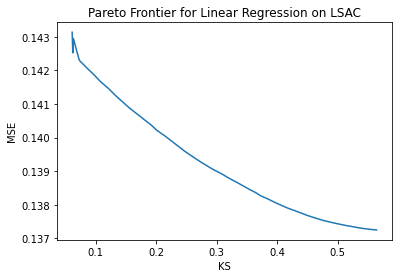

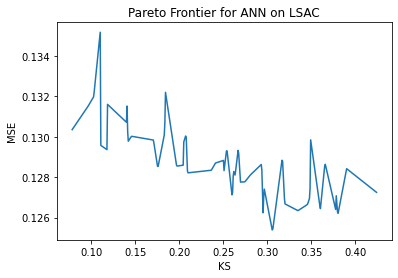

In [86]:
# Pareto frontier plot of linear regression
interploation_model = interp1d(KS_LR, MSE_LR, kind = "linear")

X_LR=np.linspace(KS_LR.min(), KS_LR.max(), 500)
Y_LR=interploation_model(X_LR)
 
plt.plot(X_LR, Y_LR)
plt.title("Pareto Frontier for Linear Regression on LSAC")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()

# Pareto frontier plot of ANN
interploation_model = interp1d(KS_ANN, MSE_ANN, kind = "linear")
 
X_ANN=np.linspace(KS_ANN.min(), KS_ANN.max(), 500)
Y_ANN=interploation_model(X_ANN)
 
plt.plot(X_ANN, Y_ANN)
plt.title("Pareto Frontier for ANN on LSAC")
plt.xlabel("KS")
plt.ylabel("MSE")
plt.show()


## MSE and KS of Linear Regression and ANN via the Post-processing Approach in "Fair Regression with Wasserstein Barycenters" by Chzhen and etc..
We implement the post-processing approach ourselves since the authors of "Fair Regression with Wasserstein Barycenters" did not post their code. See the implementation in "Implementation of Fair Regression with Wasserstein Barycenters.py" and the resulting MSE, KS, and time recording are listed below.

In [87]:
MSE_chzhen_list = [0.14059956098698873,
  0.15205907957654569,
  0.14306635635272527,
  0.137330269234612,
  0.14157344270429173]
KS_chzhen_list = [0.06677001400473871,
  0.07102566977171455,
  0.0809844000648367,
  0.10207056286564303,
  0.09354462955438168]
time_chzhen_list = [6271.129221878,
  6865.3056517429995,
  6682.171541546999,
  6639.455036824998,
  6527.266549924003]
MSE_chzhen_list_ANN = [0.12766690849887072,
  0.13626017341342314,
  0.13500187211504142,
  0.12863376158702094,
  0.131659848138675]
KS_chzhen_list_ANN = [0.10858516906978588,
  0.05771306278644443,
  0.05409952434450649,
  0.08615697941417247,
  0.06271163483678721]
time_chzhen_list_ANN = [7593.746866715002,
  7754.263235025006,
  6561.0633790659995,
  6227.002467115002,
  6511.589547302006]

## Generate Figures

In [88]:
# due to the randomness in training ANN, we use the MSE(KS)_origin_list_ANN directly from the MSE(KS)_path_list_ANN to have better visualization
# but one could choose to skip this step and derive similar figures
MSE_origin_list_ANN = np.array(MSE_path_list_ANN)[:,0]
KS_origin_list_ANN = np.array(KS_path_list_ANN)[:,0]
MSE_fair_list_ANN = np.array(MSE_path_list_ANN)[:,49]
KS_fair_list_ANN = np.array(KS_path_list_ANN)[:,49]

# mean and standard deviation of the MSE and KS resulting from the comparison methods:
MSE_origin_mean = np.mean(MSE_origin_list)
MSE_d_mean = np.mean(MSE_d_list)
MSE_fair_mean = np.mean(MSE_fair_list)
MSE_chzhen_mean = np.mean(MSE_chzhen_list)
MSE_origin_std = np.std(MSE_origin_list)
MSE_d_std = np.std(MSE_d_list)
MSE_fair_std = np.std(MSE_fair_list)
MSE_chzhen_std = np.std(MSE_chzhen_list)
KS_origin_mean = np.mean(KS_origin_list)
KS_d_mean = np.mean(KS_d_list)
KS_fair_mean = np.mean(KS_fair_list)
KS_chzhen_mean = np.mean(KS_chzhen_list)
KS_origin_std = np.std(KS_origin_list)
KS_d_std = np.std(KS_d_list)
KS_fair_std = np.std(KS_fair_list)
KS_chzhen_std = np.std(KS_chzhen_list)
MSE_origin_mean_ANN = np.mean(MSE_origin_list_ANN)
MSE_d_mean_ANN = np.mean(MSE_d_list_ANN)
MSE_fair_mean_ANN = np.mean(MSE_fair_list_ANN)
MSE_chzhen_mean_ANN = np.mean(MSE_chzhen_list_ANN)
MSE_origin_std_ANN = np.std(MSE_origin_list_ANN)
MSE_d_std_ANN = np.std(MSE_d_list_ANN)
MSE_fair_std_ANN = np.std(MSE_fair_list_ANN)
MSE_chzhen_std_ANN = np.std(MSE_chzhen_list_ANN)
KS_origin_mean_ANN = np.mean(KS_origin_list_ANN)
KS_d_mean_ANN = np.mean(KS_d_list_ANN)
KS_fair_mean_ANN = np.mean(KS_fair_list_ANN)
KS_chzhen_mean_ANN = np.mean(KS_chzhen_list_ANN)
KS_origin_std_ANN = np.std(KS_origin_list_ANN)
KS_d_std_ANN = np.std(KS_d_list_ANN)
KS_fair_std_ANN = np.std(KS_fair_list_ANN)
KS_chzhen_std_ANN = np.std(KS_chzhen_list_ANN)

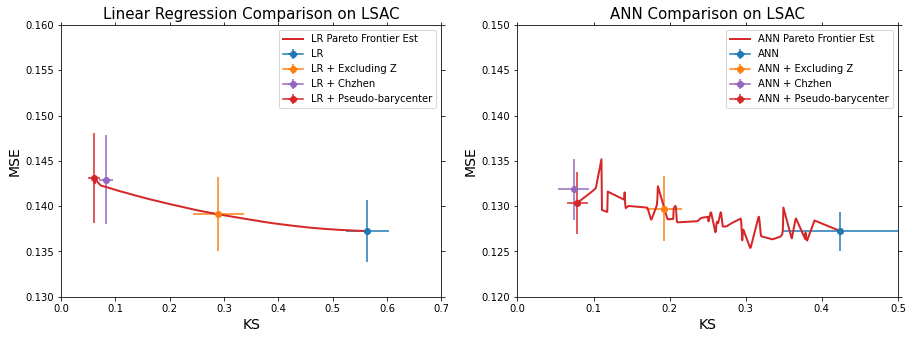

In [89]:
# Generate Figure
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].errorbar(KS_origin_mean, MSE_origin_mean, xerr=KS_origin_std, yerr=MSE_origin_std, fmt='-o') # LR
axs[0].errorbar(KS_d_mean, MSE_d_mean, xerr=KS_d_std, yerr=MSE_d_std, fmt='-o') # LR + Excluding Z
axs[0].errorbar(KS_chzhen_mean, MSE_chzhen_mean, xerr=KS_chzhen_std, yerr=MSE_chzhen_std, fmt='-o',color = '#9467bd') # LR + chzhen
axs[0].errorbar(KS_fair_mean, MSE_fair_mean, xerr=KS_fair_std, yerr=MSE_fair_std, fmt='-o',color = '#d62728') # LR + pseudo-barycenter
axs[0].plot(X_LR,Y_LR,linewidth = 2, color = '#d62728')

axs[0].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[0].legend(['LR Pareto Frontier Est','LR','LR + Excluding Z','LR + Chzhen','LR + Pseudo-barycenter'], 
           loc='best',fancybox=True)

axs[0].set_ylabel('MSE', fontsize=14)
axs[0].set_xlabel('KS', fontsize=14)
axs[0].set_title(f"Linear Regression Comparison on LSAC", fontsize=15)
axs[0].set_ylim(0.13, 0.16)
axs[0].set_xlim(0, 0.7)


axs[1].errorbar(KS_origin_mean_ANN, MSE_origin_mean_ANN, xerr=KS_origin_std_ANN, yerr=MSE_origin_std_ANN, fmt='-o') # ANN
axs[1].errorbar(KS_d_mean_ANN, MSE_d_mean_ANN, xerr=KS_d_std_ANN, yerr=MSE_d_std_ANN, fmt='-o') # ANN + Dropping D
axs[1].errorbar(KS_chzhen_mean_ANN, MSE_chzhen_mean_ANN, xerr=KS_chzhen_std_ANN, yerr=MSE_chzhen_std_ANN, fmt='-o',color = '#9467bd') # ANN + chzhen
axs[1].errorbar(KS_fair_mean_ANN, MSE_fair_mean_ANN, xerr=KS_fair_std_ANN, yerr=MSE_fair_std_ANN, fmt='-o',color = '#d62728') # ANN + pseudo-barycenter
axs[1].plot(X_ANN,Y_ANN,linewidth = 2, color = '#d62728')

#fig.axes.get_xaxis().set_visible(False)

axs[1].tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="on", right="off", labelleft="on")  

axs[1].legend(['ANN Pareto Frontier Est','ANN','ANN + Excluding Z','ANN + Chzhen','ANN + Pseudo-barycenter'], 
           loc='best',fancybox=True)

axs[1].set_ylabel('MSE', fontsize=14)
axs[1].set_xlabel('KS', fontsize=14)
axs[1].set_title(f"ANN Comparison on LSAC", fontsize=15)
axs[1].set_ylim(0.12, 0.15)
axs[1].set_xlim(0, 0.5)

fig.subplots_adjust(wspace=0.2,hspace=0.2)
plt.savefig('Pareto Frontier LSAC', dpi=400,bbox_inches='tight')